In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import jpholiday
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error

In [2]:
train=pd.read_csv("./train.csv", parse_dates=[0]) # 日付をdatetime型で取得
test=pd.read_csv("./test.csv", parse_dates=[0])
submit_sample=pd.read_csv("./sample_submit.csv", header=None)

df = pd.concat([train, test], sort=False)
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  2466 non-null   datetime64[ns]
 1   y         2101 non-null   float64       
 2   client    2466 non-null   int64         
 3   close     2466 non-null   int64         
 4   price_am  2466 non-null   int64         
 5   price_pm  2466 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 134.9 KB


,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17.0,0,0,-1,-1
1,2010-07-02,18.0,0,0,-1,-1
2,2010-07-03,20.0,0,0,-1,-1
3,2010-07-04,20.0,0,0,-1,-1
4,2010-07-05,14.0,0,0,-1,-1
5,2010-07-06,14.0,0,0,-1,-1
6,2010-07-07,4.0,0,0,-1,-1
7,2010-07-08,10.0,0,0,-1,-1
8,2010-07-09,12.0,0,0,-1,-1
9,2010-07-10,21.0,0,0,-1,-1


### 日本の休日

In [3]:
i = 0
df['holiday'] = np.zeros((len(df),))
jpholiday_list =[]
for date in df['datetime'].dt.date:
    DateJ = dt.date(date.year,date.month,date.day)
    jpholiday_list.append(jpholiday.is_holiday(DateJ))
    i += 1

df['holiday'] = jpholiday_list    
df['holiday'].value_counts()

False    2353
True      113
Name: holiday, dtype: int64

In [4]:
df.loc[df['price_am'] == -1, 'price_am'] = np.nan
df.loc[df['price_pm'] == -1, 'price_pm'] = np.nan
df.loc[df['close'] == 1, 'price_am'] = 0
df.loc[df['close'] == 1, 'price_pm'] = 0
df.head()

,datetime,y,client,close,price_am,price_pm,holiday
0,2010-07-01,17.0,0,0,NaN,NaN,False
1,2010-07-02,18.0,0,0,NaN,NaN,False
2,2010-07-03,20.0,0,0,NaN,NaN,False
3,2010-07-04,20.0,0,0,NaN,NaN,False
4,2010-07-05,14.0,0,0,NaN,NaN,False


In [5]:
### datimeをdatetime64[ns]型に変更。

In [6]:
#df['datetime'] = df.datetime.map(dt.datetime.timestamp)
#df['datetime'] = df['datetime'].dt.to_pydatetime()
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday

In [7]:
#df.info()
#df['epoch'] = df['datetime'].map(pd.Timestamp.timestamp) # TimeStamp型に変更
#display(df['epoch'])

In [8]:
#df=df.drop(['datetime','year'], axis=1)
df=df.drop(['datetime'], axis=1)

### Fill na

In [9]:
df['price_am'] = df.groupby(['month', 'weekday'])['price_am'].transform(lambda x: x.fillna(x.mean()))
df['price_pm'] = df.groupby(['month', 'weekday'])['price_pm'].transform(lambda x: x.fillna(x.mean()))

### New features

In [10]:
df['price'] = (df['price_am'] + df['price_pm'])/2
df['price_times'] = df['price_am'] * df['price_pm']

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   y            2101 non-null   float64
 1   client       2466 non-null   int64  
 2   close        2466 non-null   int64  
 3   price_am     2466 non-null   float64
 4   price_pm     2466 non-null   float64
 5   holiday      2466 non-null   bool   
 6   year         2466 non-null   int64  
 7   month        2466 non-null   int64  
 8   day          2466 non-null   int64  
 9   weekday      2466 non-null   int64  
 10  price        2466 non-null   float64
 11  price_times  2466 non-null   float64
dtypes: bool(1), float64(5), int64(6)
memory usage: 233.6 KB


In [12]:
df['client'] = df['client'].astype(str)
df['close'] = df['close'].astype(str)
df['month'] = df['month'].astype(str)
df['weekday'] = df['weekday'].astype(str)
df['day'] = df['day'].astype(str)

In [13]:
pd.set_option('display.max_rows', None)
print(df.groupby(['month', 'weekday'])['price_am','price_pm','y'].mean())
print(df.groupby(['year'])['price_am','price_pm','y'].mean())

               price_am  price_pm          y
month weekday                               
1     0        0.129032  0.000000  23.423077
      1        0.096774  0.064516  21.846154
      2        0.033333  0.000000  22.692308
      3        0.161290  0.096774  21.296296
      4        0.258065  0.161290  27.444444
      5        0.806452  0.419355  36.296296
      6        0.375000  0.218750  32.666667
10    0        0.518519  0.192308  28.538462
      1        0.192308  0.076923  25.769231
      2        0.185185  0.074074  28.148148
      3        0.222222  0.148148  29.481481
      4        0.500000  0.269231  32.222222
      5        1.629630  1.111111  39.000000
      6        1.346154  0.730769  35.269231
11    0        0.120000  0.040000  28.576923
      1        0.153846  0.076923  24.000000
      2        0.153846  0.076923  24.280000
      3        0.160000  0.080000  26.120000
      4        0.423077  0.269231  32.269231
      5        1.423077  1.000000  38.884615
      6   

<ipython-input-13-ab1e28b0b82f>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(df.groupby(['month', 'weekday'])['price_am','price_pm','y'].mean())
<ipython-input-13-ab1e28b0b82f>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(df.groupby(['year'])['price_am','price_pm','y'].mean())


In [14]:
#divide dataset into two parts(categorical, contineous)
categorical, numerical = [],[]
for z in df.columns:
    t = df.dtypes[z]
    if t=='object':
        categorical.append(z)
    else:
        numerical.append(z)
print("CategoricaL:\n{}".format(categorical))
print("\nNumericaL:\n{}".format(numerical))

CategoricaL:
['client', 'close', 'month', 'day', 'weekday']

NumericaL:
['y', 'price_am', 'price_pm', 'holiday', 'year', 'price', 'price_times']


### Pandas Profining

In [15]:
#import pandas_profiling

#df.profile_report()

### Heat map for Correlation coefficient

<AxesSubplot:>

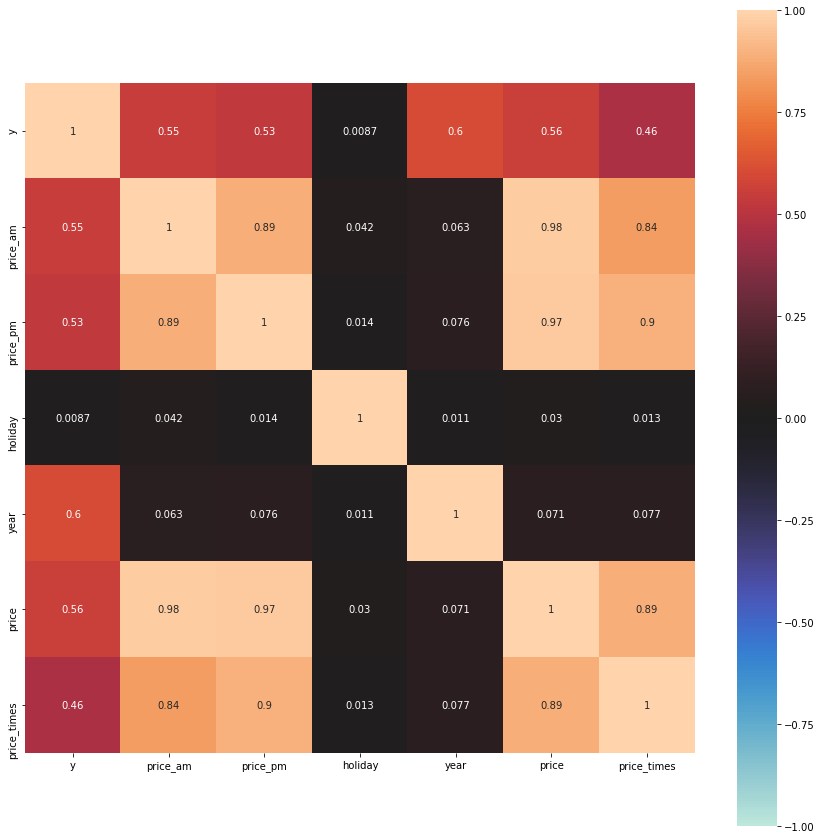

In [16]:
df_corr = df.corr()
plt.figure(figsize=(15, 15)) 
sns.heatmap(df_corr, vmax=1, vmin=-1, center=0, square=True, annot=True)

### Histogram

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


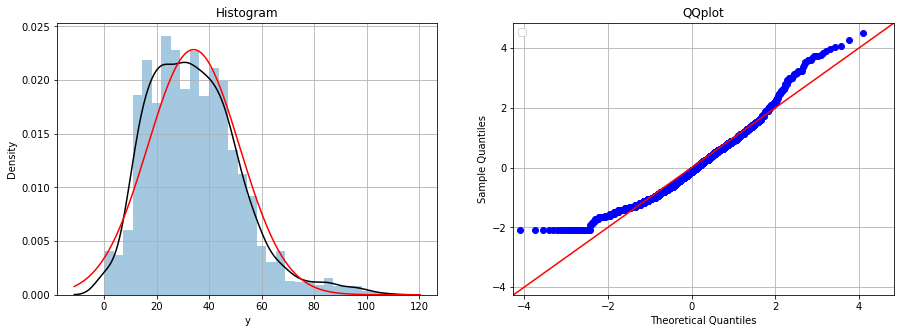

In [17]:
fig, ax = plt.subplots(1,2, figsize= (15,5))
# Histogram
sns.distplot(
    train['y'], label='y',
    kde_kws={'label': 'kde','color':'k'},
    fit=norm,fit_kws={'label': 'norm','color':'red'},
    ax = ax[0]
)
ax[0].set_title("Histogram")
ax[0].grid(True)

# QQplot
sm.qqplot(train['y'], stats.t, distargs=(4,),fit=True, line="45", ax = ax[1])
ax[1].set_title("QQplot")
ax[1].grid(True)

plt.legend() # 凡例を表示
plt.show() #グラフ表示

### Dummy

In [18]:
df =pd.get_dummies(df, columns=categorical, drop_first=True)

In [19]:
df.head(10)

,y,price_am,price_pm,holiday,year,price,price_times,client_1,close_1,month_10,...,day_6,day_7,day_8,day_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,17.0,0.192308,0.076923,False,2010,0.134615,0.014793,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,18.0,0.692308,0.423077,False,2010,0.557692,0.292899,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,20.0,1.807692,1.192308,False,2010,1.500000,2.155325,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,20.0,1.407407,0.925926,False,2010,1.166667,1.303155,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,14.0,0.346154,0.192308,False,2010,0.269231,0.066568,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,14.0,0.333333,0.148148,False,2010,0.240741,0.049383,0,0,0,...,1,0,0,0,1,0,0,0,0,0
6,4.0,0.259259,0.111111,False,2010,0.185185,0.028807,0,0,0,...,0,1,0,0,0,1,0,0,0,0
7,10.0,0.192308,0.076923,False,2010,0.134615,0.014793,0,0,0,...,0,0,1,0,0,0,1,0,0,0
8,12.0,0.692308,0.423077,False,2010,0.557692,0.292899,0,0,0,...,0,0,0,1,0,0,0,1,0,0
9,21.0,1.807692,1.192308,False,2010,1.500000,2.155325,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Separate Data

In [20]:
train = df[:len(train)]
test = df[len(train):]

In [21]:
y_train = train['y']
X_train = train.drop(['y'], axis=1)
X_test = test.drop(['y'], axis=1)

In [22]:
### 線形回帰

In [23]:
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [24]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 56 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   y            2101 non-null   float64
 1   price_am     2466 non-null   float64
 2   price_pm     2466 non-null   float64
 3   holiday      2466 non-null   bool   
 4   year         2466 non-null   int64  
 5   price        2466 non-null   float64
 6   price_times  2466 non-null   float64
 7   client_1     2466 non-null   uint8  
 8   close_1      2466 non-null   uint8  
 9   month_10     2466 non-null   uint8  
 10  month_11     2466 non-null   uint8  
 11  month_12     2466 non-null   uint8  
 12  month_2      2466 non-null   uint8  
 13  month_3      2466 non-null   uint8  
 14  month_4      2466 non-null   uint8  
 15  month_5      2466 non-null   uint8  
 16  month_6      2466 non-null   uint8  
 17  month_7      2466 non-null   uint8  
 18  month_8      2466 non-null   uint8  
 19  month_9

,y,price_am,price_pm,holiday,year,price,price_times,client_1,close_1,month_10,...,day_6,day_7,day_8,day_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,17.0,0.192308,0.076923,False,2010,0.134615,0.014793,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,18.0,0.692308,0.423077,False,2010,0.557692,0.292899,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,20.0,1.807692,1.192308,False,2010,1.500000,2.155325,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,20.0,1.407407,0.925926,False,2010,1.166667,1.303155,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,14.0,0.346154,0.192308,False,2010,0.269231,0.066568,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# データセットの標準化準備
scaler= StandardScaler()
# データセットの標準化
scaler.fit(X_train)
scaler.fit(X_test)
X_train_scaler = scaler.transform(X_train)
X_test_scaler  = scaler.transform(X_test)


In [26]:
# Lasso 交差検証準備
# clf = LassoCV(alphas=10 ** np.arange(-6, 1, 0.1), cv = 5)

params_grid = {
    'alpha': 10 ** np.arange(-6, 1, 0.1)
}
# パラメータチューニング
clf = GridSearchCV(
    estimator = Lasso(),
    param_grid = params_grid,
    cv = 5,
    scoring='r2',
    n_jobs = -1
    )
# 線形モデルの重みを学習
clf.fit(X_train_scaler, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
lasso_tuned = clf.best_estimator_

# 予測値を反映
y_lasso_pred = lasso_tuned.predict(X_train_scaler) # Trainデータに対して予測
y_lasso_test_pred = lasso_tuned.predict(X_test_scaler) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))
print(best_param)
print("R^2 = {}".format(clf.score(X_train_scaler, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_lasso_pred)))
#print(cross_val_score(clf, X_train_scaler, y_train, cv=5))

{'alpha': 0.009999999999999672}
R^2 = 0.7604623581300229
MAE = 6.614762504895048


In [27]:
import optuna.integration.lightgbm as lgb # Optuna 
#import lightgbm as lgb 
from sklearn.model_selection import KFold

evals_result = {} #結果を格納するための辞書

In [28]:
# データセットの標準化
scaler.fit(X_train)
scaler.fit(X_test)
X_train_scaler = scaler.transform(X_train)
X_test_scaler  = scaler.transform(X_test)

In [29]:
def ScalerFit(X_tr, X_tst):
    scaler.fit(X_tr)
    scaler.fit(X_tst)
    X_tr_scaler = scaler.transform(X_tr)
    X_tst_scaler  = scaler.transform(X_tst)
    return X_tr_scaler, X_tst_scaler

In [30]:
def SVC_fit(random_sts):
    # SVM
    params_grid = [
        {'C': [1, 10, 100], 'kernel':['linear']},
        {'C': [1, 10, 100], 'gamma': [0.01, 0.001], 'kernel': ['rbf']}
    ]
    # パラメータチューニング
    clf = GridSearchCV(
        estimator = SVC(),
        param_grid = params_grid,
        cv = 5,
        scoring='r2',
        n_jobs = -1
        )

    # フィッテイング
    clf.fit(X_train_scaler, y_train) 

    # チューニングしたモデル
    best_param = clf.best_params_
    svc_tuned = clf.best_estimator_

    # 予測値を反映
    y_pred = svc_tuned.predict(X_train_scaler) # Trainデータに対して予測
    y_test_pred = svc_tuned.predict(X_test_scaler) # Testデータに対して予測

    print(best_param)
    print("Score = {}".format(clf.score(X_train_scaler, y_train)))
    print("MAE = {}".format(mean_absolute_error(y_train, y_pred)))
    mae_result = mean_absolute_error(y_train, y_pred)
    
    X_train['svc'] = y_pred
    X_test['svc'] = y_test_pred

    return y_pred, y_test_pred, mae_result
    

In [31]:
def lightGBM_fit(random_sts):
    y_lgb_preds = []
    models = []
    y_lgb_oof_train = np.zeros((len(X_train),))
    cv = KFold(n_splits=5, shuffle=True, random_state=random_sts)

    params = {
        'task' : 'train',
        'boosting_type' : 'gbdt',
        'objective': 'regression',
        'metric' : 'rmse',
        'max_bin' : 255,
        'num_leaves' : 31,
        'learning_rate' : 0.05,
        'feature_fraction' : 0.9,
        'bagging_fraction' : 0.8,
        'bagging_freq': 5,
        'verbose' : -1
    }

    # Cross Validation
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
        X_tr = X_train.iloc[train_index, :]
        X_val = X_train.iloc[valid_index, :]
        y_tr = y_train.iloc[train_index]
        y_val = y_train.iloc[valid_index]
    
        # Train Dataset
        lgb_train = lgb.Dataset(X_tr, y_tr)

        # Evaluation Dataset (early_stopping_rounds)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
 #       evals_result = {} #結果を格納するための辞書
        # train
        gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_eval],
                    valid_names=['train','eval'],
                    num_boost_round=1000,
                    early_stopping_rounds=100,
                    verbose_eval=100,
                    evals_result=evals_result
                   )
        # Out-of-hold of train data
        y_lgb_oof_train[valid_index] = \
            gbm.predict(X_val, num_iteration=gbm.best_iteration)

    
        # Prediction for X_test data
        y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    
        # Append Prediction data 
        y_lgb_preds.append(y_pred)
        models.append(gbm)

    mae_result = mean_absolute_error(y_train, y_lgb_oof_train)
    print("MAE = {}".format(mae_result))
    
    X_train['lgb'] = y_lgb_oof_train
    X_test['lgb'] = sum(y_lgb_preds)/len(y_lgb_preds)

    return y_lgb_oof_train, y_lgb_preds, mae_result

In [32]:
svc_mae_result = []
lgb_mae_result = []
for i in range(0,1):
    y_svc_pred, y_svc_test_pred,mae_result = SVC_fit(i)
    X_train_scaler, X_test_scaler = ScalerFit(X_train, X_test)
    svc_mae_result.append(mae_result)
    print(X_train.tail())
    y_lgb_oof_train, y_lgb_preds, mae_result = lightGBM_fit(i)
    X_train_scaler, X_test_scaler = ScalerFit(X_train, X_test)
    lgb_mae_result.append(mae_result)
    print(X_train.tail())

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


[I 2021-06-22 14:14:42,019] A new study created in memory with name: no-name-cd28622d-2384-4c86-8758-6797d237bfc9
feature_fraction, val_score: inf:   0%|                  | 0/7 [00:00<?, ?it/s]

Score = 0.997740806718124
MAE = 0.08138981437410757
      price_am  price_pm  holiday  year  price  price_times  client_1  \
2096       5.0       4.0    False  2016    4.5         20.0         1   
2097       4.0       4.0    False  2016    4.0         16.0         1   
2098       4.0       4.0    False  2016    4.0         16.0         1   
2099       5.0       4.0    False  2016    4.5         20.0         1   
2100       5.0       4.0    False  2016    4.5         20.0         1   

      close_1  month_10  month_11  ...  day_7  day_8  day_9  weekday_1  \
2096        0         0         0  ...      0      0      0          0   
2097        0         0         0  ...      0      0      0          0   
2098        0         0         0  ...      0      0      0          1   
2099        0         0         0  ...      0      0      0          0   
2100        0         0         0  ...      0      0      0          0   

      weekday_2  weekday_3  weekday_4  weekday_5  weekday_6    s

feature_fraction, val_score: 1.112548:  14%|7    | 1/7 [00:00<00:04,  1.29it/s]

Early stopping, best iteration is:
[380]	train's rmse: 0.865916	eval's rmse: 1.11255
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.79052	eval's rmse: 2.09304
[200]	train's rmse: 1.21973	eval's rmse: 1.5608
[300]	train's rmse: 1.04933	eval's rmse: 1.4113
[400]	train's rmse: 0.97136	eval's rmse: 1.35738
[500]	train's rmse: 0.918226	eval's rmse: 1.34056
[600]	train's rmse: 0.872488	eval's rmse: 1.32473
[700]	train's rmse: 0.835532	eval's rmse: 1.31226
[800]	train's rmse: 0.799576	eval's rmse: 1.31423
Early stopping, best iteration is:
[732]	train's rmse: 0.825624	eval's rmse: 1.312


feature_fraction, val_score: 1.112548:  29%|#4   | 2/7 [00:02<00:05,  1.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.65089	eval's rmse: 1.93669
[200]	train's rmse: 1.16286	eval's rmse: 1.46756
[300]	train's rmse: 1.01862	eval's rmse: 1.35175
[400]	train's rmse: 0.944734	eval's rmse: 1.31404
[500]	train's rmse: 0.89044	eval's rmse: 1.30292
[600]	train's rmse: 0.845195	eval's rmse: 1.29289
[700]	train's rmse: 0.805827	eval's rmse: 1.29061


feature_fraction, val_score: 1.112548:  43%|##1  | 3/7 [00:03<00:04,  1.11s/it]

[800]	train's rmse: 0.768932	eval's rmse: 1.29559
Early stopping, best iteration is:
[703]	train's rmse: 0.80491	eval's rmse: 1.29026
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.32207	eval's rmse: 1.50209
[200]	train's rmse: 1.04888	eval's rmse: 1.27451
[300]	train's rmse: 0.96062	eval's rmse: 1.22575
[400]	train's rmse: 0.897407	eval's rmse: 1.20915
[500]	train's rmse: 0.849907	eval's rmse: 1.21241


feature_fraction, val_score: 1.112548:  57%|##8  | 4/7 [00:04<00:03,  1.03s/it]

Early stopping, best iteration is:
[475]	train's rmse: 0.860883	eval's rmse: 1.20423
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.0953	eval's rmse: 1.15787
[200]	train's rmse: 0.964342	eval's rmse: 1.11287


feature_fraction, val_score: 1.101008:  71%|###5 | 5/7 [00:04<00:01,  1.21it/s]

[300]	train's rmse: 0.899267	eval's rmse: 1.11431
Early stopping, best iteration is:
[210]	train's rmse: 0.956309	eval's rmse: 1.10101
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.05094	eval's rmse: 1.04676


feature_fraction, val_score: 1.032073:  86%|####2| 6/7 [00:04<00:00,  1.55it/s]

Early stopping, best iteration is:
[92]	train's rmse: 1.066	eval's rmse: 1.03207
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 2.35987	eval's rmse: 2.68497
[200]	train's rmse: 1.47001	eval's rmse: 1.85464
[300]	train's rmse: 1.20498	eval's rmse: 1.6079
[400]	train's rmse: 1.07596	eval's rmse: 1.49814
[500]	train's rmse: 1.00082	eval's rmse: 1.43704
[600]	train's rmse: 0.946873	eval's rmse: 1.40381
[700]	train's rmse: 0.90485	eval's rmse: 1.38363
[800]	train's rmse: 0.865435	eval's rmse: 1.37608
[900]	train's rmse: 0.835745	eval's rmse: 1.37181
[1000]	train's rmse: 0.806917	eval's rmse: 1.37035
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.806917	eval's rmse: 1.37035


num_leaves, val_score: 1.032073:   0%|                  | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.04595	eval's rmse: 1.04336


num_leaves, val_score: 1.031056:   5%|5         | 1/20 [00:00<00:07,  2.54it/s]

Early stopping, best iteration is:
[92]	train's rmse: 1.06118	eval's rmse: 1.03106
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.04595	eval's rmse: 1.04336
Early stopping, best iteration is:
[92]	train's rmse: 1.06118	eval's rmse: 1.03106


num_leaves, val_score: 1.031056:  10%|#         | 2/20 [00:00<00:07,  2.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.04595	eval's rmse: 1.04336


num_leaves, val_score: 1.031056:  15%|#5        | 3/20 [00:01<00:07,  2.29it/s]

Early stopping, best iteration is:
[92]	train's rmse: 1.06118	eval's rmse: 1.03106
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.04595	eval's rmse: 1.04336


num_leaves, val_score: 1.031056:  20%|##        | 4/20 [00:01<00:06,  2.48it/s]

Early stopping, best iteration is:
[92]	train's rmse: 1.06118	eval's rmse: 1.03106
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031056:  20%|##        | 4/20 [00:02<00:06,  2.48it/s]

[100]	train's rmse: 1.04595	eval's rmse: 1.04336
Early stopping, best iteration is:
[92]	train's rmse: 1.06118	eval's rmse: 1.03106


num_leaves, val_score: 1.031056:  25%|##5       | 5/20 [00:02<00:06,  2.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.04595	eval's rmse: 1.04336


num_leaves, val_score: 1.031056:  30%|###       | 6/20 [00:02<00:05,  2.56it/s]

Early stopping, best iteration is:
[92]	train's rmse: 1.06118	eval's rmse: 1.03106
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.04595	eval's rmse: 1.04336


num_leaves, val_score: 1.031056:  35%|###5      | 7/20 [00:02<00:04,  2.64it/s]

Early stopping, best iteration is:
[92]	train's rmse: 1.06118	eval's rmse: 1.03106
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031056:  35%|###5      | 7/20 [00:03<00:04,  2.64it/s]

[100]	train's rmse: 1.04595	eval's rmse: 1.04336
Early stopping, best iteration is:
[92]	train's rmse: 1.06118	eval's rmse: 1.03106


num_leaves, val_score: 1.031056:  40%|####      | 8/20 [00:03<00:04,  2.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.04595	eval's rmse: 1.04336


num_leaves, val_score: 1.031056:  45%|####5     | 9/20 [00:03<00:04,  2.56it/s]

Early stopping, best iteration is:
[92]	train's rmse: 1.06118	eval's rmse: 1.03106
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.04595	eval's rmse: 1.04336


num_leaves, val_score: 1.031056:  50%|####5    | 10/20 [00:03<00:03,  2.59it/s]

Early stopping, best iteration is:
[92]	train's rmse: 1.06118	eval's rmse: 1.03106
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.05721	eval's rmse: 1.05644


num_leaves, val_score: 1.031056:  55%|####9    | 11/20 [00:04<00:03,  2.85it/s]

Early stopping, best iteration is:
[92]	train's rmse: 1.07131	eval's rmse: 1.04247
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.031056:  60%|#####3   | 12/20 [00:04<00:02,  2.84it/s]

[100]	train's rmse: 1.04595	eval's rmse: 1.04336
Early stopping, best iteration is:
[92]	train's rmse: 1.06118	eval's rmse: 1.03106
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.04595	eval's rmse: 1.04336


num_leaves, val_score: 1.031056:  65%|#####8   | 13/20 [00:05<00:02,  2.61it/s]

Early stopping, best iteration is:
[92]	train's rmse: 1.06118	eval's rmse: 1.03106
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.07856	eval's rmse: 1.05303


num_leaves, val_score: 1.031056:  70%|######3  | 14/20 [00:05<00:02,  2.96it/s]

Early stopping, best iteration is:
[91]	train's rmse: 1.09468	eval's rmse: 1.03932
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.04595	eval's rmse: 1.04336

num_leaves, val_score: 1.031056:  70%|######3  | 14/20 [00:05<00:02,  2.96it/s]


Early stopping, best iteration is:
[92]	train's rmse: 1.06118	eval's rmse: 1.03106


num_leaves, val_score: 1.031056:  75%|######7  | 15/20 [00:05<00:01,  2.80it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.04595	eval's rmse: 1.04336


num_leaves, val_score: 1.031056:  80%|#######2 | 16/20 [00:06<00:01,  2.71it/s]

Early stopping, best iteration is:
[92]	train's rmse: 1.06118	eval's rmse: 1.03106
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.030829:  85%|#######6 | 17/20 [00:06<00:01,  2.67it/s]

[100]	train's rmse: 1.04835	eval's rmse: 1.04677
Early stopping, best iteration is:
[92]	train's rmse: 1.06317	eval's rmse: 1.03083
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.04595	eval's rmse: 1.04336


num_leaves, val_score: 1.030829:  90%|########1| 18/20 [00:06<00:00,  2.51it/s]

Early stopping, best iteration is:
[92]	train's rmse: 1.06118	eval's rmse: 1.03106
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.030829:  90%|########1| 18/20 [00:07<00:00,  2.51it/s]

[100]	train's rmse: 1.04595	eval's rmse: 1.04336
Early stopping, best iteration is:
[92]	train's rmse: 1.06118	eval's rmse: 1.03106


bagging, val_score: 1.005708:   0%|                     | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.14183	eval's rmse: 1.04122
[200]	train's rmse: 1.05724	eval's rmse: 1.01492
[300]	train's rmse: 1.03623	eval's rmse: 1.02071
Early stopping, best iteration is:
[209]	train's rmse: 1.05471	eval's rmse: 1.00571
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.960668:  10%|#3           | 1/10 [00:00<00:01,  5.78it/s]

[100]	train's rmse: 1.12809	eval's rmse: 0.993996
[200]	train's rmse: 1.03808	eval's rmse: 0.969948
Early stopping, best iteration is:
[132]	train's rmse: 1.07168	eval's rmse: 0.960668
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.37625	eval's rmse: 1.39418
[200]	train's rmse: 1.26424	eval's rmse: 1.37027


bagging, val_score: 0.960668:  20%|##6          | 2/10 [00:00<00:01,  5.61it/s]

[300]	train's rmse: 1.22663	eval's rmse: 1.37464
Early stopping, best iteration is:
[210]	train's rmse: 1.26402	eval's rmse: 1.36318
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.28484	eval's rmse: 1.31158
[200]	train's rmse: 1.18247	eval's rmse: 1.30108
Early stopping, best iteration is:
[190]	train's rmse: 1.18898	eval's rmse: 1.29773


bagging, val_score: 0.940323:  40%|#####2       | 4/10 [00:00<00:00,  6.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.11345	eval's rmse: 0.972362
[200]	train's rmse: 1.0343	eval's rmse: 0.954866
Early stopping, best iteration is:
[122]	train's rmse: 1.07018	eval's rmse: 0.940323
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.23787	eval's rmse: 1.28571


bagging, val_score: 0.940323:  50%|######5      | 5/10 [00:00<00:00,  6.02it/s]

[200]	train's rmse: 1.15265	eval's rmse: 1.33803
Early stopping, best iteration is:
[126]	train's rmse: 1.2032	eval's rmse: 1.26515
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.57431	eval's rmse: 1.65207
[200]	train's rmse: 1.40462	eval's rmse: 1.61708
[300]	train's rmse: 1.31881	eval's rmse: 1.59564


bagging, val_score: 0.940323:  60%|#######8     | 6/10 [00:01<00:00,  4.46it/s]

[400]	train's rmse: 1.25794	eval's rmse: 1.57112
[500]	train's rmse: 1.22413	eval's rmse: 1.55302
[600]	train's rmse: 1.20102	eval's rmse: 1.54964
Early stopping, best iteration is:
[530]	train's rmse: 1.21537	eval's rmse: 1.54191
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.940323:  70%|#########1   | 7/10 [00:01<00:00,  4.75it/s]

[100]	train's rmse: 1.15977	eval's rmse: 1.09609
[200]	train's rmse: 1.06141	eval's rmse: 1.06106
Early stopping, best iteration is:
[126]	train's rmse: 1.1106	eval's rmse: 1.05386
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.12481	eval's rmse: 0.989163


bagging, val_score: 0.940323:  90%|###########7 | 9/10 [00:01<00:00,  5.31it/s]

[200]	train's rmse: 1.04714	eval's rmse: 0.975204
Early stopping, best iteration is:
[144]	train's rmse: 1.06459	eval's rmse: 0.956264
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.43053	eval's rmse: 1.46574
[200]	train's rmse: 1.29649	eval's rmse: 1.45594
Early stopping, best iteration is:
[126]	train's rmse: 1.38168	eval's rmse: 1.41916


feature_fraction_stage2, val_score: 0.940323:   0%|      | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.40293	eval's rmse: 1.41466
[200]	train's rmse: 1.29759	eval's rmse: 1.39557
[300]	train's rmse: 1.2335	eval's rmse: 1.40179
Early stopping, best iteration is:
[247]	train's rmse: 1.25813	eval's rmse: 1.37128
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.940323:  33%|3| 1/3 [00:00<00:00,  4.29it[I 2021-06-22 14:14:58,095] Trial 37 finished with value: 1.0184765995638156 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 1.0184765995638156.
feature_fraction_stage2, val_score: 0.940323:  33%|3| 1/3 [00:00<00:00,  4.29it

[100]	train's rmse: 1.26818	eval's rmse: 1.17535
[200]	train's rmse: 1.09735	eval's rmse: 1.03317
[300]	train's rmse: 1.04971	eval's rmse: 1.0214
[400]	train's rmse: 1.02278	eval's rmse: 1.02861
Early stopping, best iteration is:
[307]	train's rmse: 1.04746	eval's rmse: 1.01848
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.940323:  67%|6| 2/3 [00:00<00:00,  4.27it[I 2021-06-22 14:14:58,327] Trial 38 finished with value: 1.0301884241523238 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 1.0184765995638156.


[100]	train's rmse: 1.29173	eval's rmse: 1.21059
[200]	train's rmse: 1.108	eval's rmse: 1.04881
[300]	train's rmse: 1.05624	eval's rmse: 1.03152
[400]	train's rmse: 1.02734	eval's rmse: 1.03277
Early stopping, best iteration is:
[324]	train's rmse: 1.04745	eval's rmse: 1.03019


feature_fraction_stage2, val_score: 0.940323: 100%|#| 3/3 [00:00<00:00,  4.97it[I 2021-06-22 14:14:58,489] Trial 39 finished with value: 0.9766026681364548 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 39 with value: 0.9766026681364548.
feature_fraction_stage2, val_score: 0.940323: 100%|#| 3/3 [00:00<00:00,  4.76it
regularization_factors, val_score: 0.940323:   0%|      | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.16049	eval's rmse: 1.0398
[200]	train's rmse: 1.05494	eval's rmse: 0.97834
Early stopping, best iteration is:
[190]	train's rmse: 1.05914	eval's rmse: 0.976603
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.936538:   5%| | 1/20 [00:00<00:03,  5.81it[I 2021-06-22 14:14:58,682] Trial 40 finished with value: 0.9365383916954305 and parameters: {'lambda_l1': 0.0008246607870535943, 'lambda_l2': 5.575275140213245}. Best is trial 40 with value: 0.9365383916954305.
regularization_factors, val_score: 0.936538:   5%| | 1/20 [00:00<00:03,  5.81it

[100]	train's rmse: 1.15622	eval's rmse: 1.01539
[200]	train's rmse: 1.04258	eval's rmse: 0.948294
Early stopping, best iteration is:
[140]	train's rmse: 1.0674	eval's rmse: 0.936538
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.11353	eval's rmse: 0.970072
[200]	train's rmse: 1.0333	eval's rmse: 0.956297


regularization_factors, val_score: 0.936538:  15%|1| 3/20 [00:00<00:02,  6.39it[I 2021-06-22 14:14:58,986] Trial 42 finished with value: 0.9407394126655209 and parameters: {'lambda_l1': 2.8115892519749655, 'lambda_l2': 0.21847700038547774}. Best is trial 40 with value: 0.9365383916954305.
regularization_factors, val_score: 0.936538:  15%|1| 3/20 [00:00<00:02,  6.39it

Early stopping, best iteration is:
[122]	train's rmse: 1.07022	eval's rmse: 0.939348
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.12023	eval's rmse: 0.978215
[200]	train's rmse: 1.04004	eval's rmse: 0.95503
Early stopping, best iteration is:
[133]	train's rmse: 1.06529	eval's rmse: 0.940739


regularization_factors, val_score: 0.936538:  20%|2| 4/20 [00:00<00:02,  6.31it[I 2021-06-22 14:14:59,137] Trial 43 finished with value: 0.9373507972049645 and parameters: {'lambda_l1': 0.011491509162284932, 'lambda_l2': 0.298241770434667}. Best is trial 40 with value: 0.9365383916954305.
regularization_factors, val_score: 0.936538:  20%|2| 4/20 [00:00<00:02,  6.31it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.11628	eval's rmse: 0.971104
[200]	train's rmse: 1.03489	eval's rmse: 0.954643
Early stopping, best iteration is:
[127]	train's rmse: 1.06614	eval's rmse: 0.937351
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.11479	eval's rmse: 0.970194


regularization_factors, val_score: 0.936538:  25%|2| 5/20 [00:00<00:02,  5.86it[I 2021-06-22 14:14:59,330] Trial 44 finished with value: 0.9384799490889989 and parameters: {'lambda_l1': 0.34285938712664726, 'lambda_l2': 0.0008910109293563208}. Best is trial 40 with value: 0.9365383916954305.
regularization_factors, val_score: 0.936538:  25%|2| 5/20 [00:00<00:02,  5.86it

[200]	train's rmse: 1.03483	eval's rmse: 0.954936
Early stopping, best iteration is:
[131]	train's rmse: 1.06359	eval's rmse: 0.93848
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.14221	eval's rmse: 0.999898
[200]	train's rmse: 1.04994	eval's rmse: 0.945104
Early stopping, best iteration is:
[144]	train's rmse: 1.06894	eval's rmse: 0.938807

regularization_factors, val_score: 0.936538:  35%|3| 7/20 [00:01<00:02,  6.02it[I 2021-06-22 14:14:59,674] Trial 46 finished with value: 0.9393045766339575 and parameters: {'lambda_l1': 3.676824906028693, 'lambda_l2': 1.3931401051303425}. Best is trial 40 with value: 0.9365383916954305.
regularization_factors, val_score: 0.936538:  35%|3| 7/20 [00:01<00:02,  6.02it


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.13075	eval's rmse: 0.98663
[200]	train's rmse: 1.04361	eval's rmse: 0.950296
Early stopping, best iteration is:
[135]	train's rmse: 1.06736	eval's rmse: 0.939305


regularization_factors, val_score: 0.936538:  40%|4| 8/20 [00:01<00:01,  6.07it[I 2021-06-22 14:14:59,826] Trial 47 finished with value: 0.9391747102950211 and parameters: {'lambda_l1': 7.208194885817232, 'lambda_l2': 1.6310601555145447e-06}. Best is trial 40 with value: 0.9365383916954305.
regularization_factors, val_score: 0.936538:  40%|4| 8/20 [00:01<00:01,  6.07it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.1288	eval's rmse: 0.983304
[200]	train's rmse: 1.04663	eval's rmse: 0.946318
Early stopping, best iteration is:
[137]	train's rmse: 1.06854	eval's rmse: 0.939175
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.115	eval's rmse: 0.970517


regularization_factors, val_score: 0.936538:  45%|4| 9/20 [00:01<00:01,  6.13it[I 2021-06-22 14:14:59,987] Trial 48 finished with value: 0.9388200410036033 and parameters: {'lambda_l1': 0.48805398560519875, 'lambda_l2': 2.4732296799825227e-06}. Best is trial 40 with value: 0.9365383916954305.
regularization_factors, val_score: 0.936538:  45%|4| 9/20 [00:01<00:01,  6.13it

[200]	train's rmse: 1.03544	eval's rmse: 0.954954
Early stopping, best iteration is:
[132]	train's rmse: 1.06359	eval's rmse: 0.93882
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.11366	eval's rmse: 0.968196
[200]	train's rmse: 1.03355	eval's rmse: 0.95422
Early stopping, best iteration is:
[127]	train's rmse: 1.06675	eval's rmse: 0.93861

regularization_factors, val_score: 0.936538:  55%|5| 11/20 [00:01<00:01,  6.24i[I 2021-06-22 14:15:00,302] Trial 50 finished with value: 0.9403226006931249 and parameters: {'lambda_l1': 7.720122716910661e-07, 'lambda_l2': 1.0862609190257282e-08}. Best is trial 40 with value: 0.9365383916954305.
regularization_factors, val_score: 0.936538:  55%|5| 11/20 [00:01<00:01,  6.24i


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.11345	eval's rmse: 0.972362
[200]	train's rmse: 1.0343	eval's rmse: 0.954866
Early stopping, best iteration is:
[122]	train's rmse: 1.07018	eval's rmse: 0.940323


regularization_factors, val_score: 0.936538:  60%|6| 12/20 [00:02<00:01,  5.68i[I 2021-06-22 14:15:00,523] Trial 51 finished with value: 0.9377522507662772 and parameters: {'lambda_l1': 9.442981754591336e-05, 'lambda_l2': 7.644732982099187}. Best is trial 40 with value: 0.9365383916954305.
regularization_factors, val_score: 0.936538:  60%|6| 12/20 [00:02<00:01,  5.68i

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.17634	eval's rmse: 1.04458
[200]	train's rmse: 1.04412	eval's rmse: 0.948799
Early stopping, best iteration is:
[149]	train's rmse: 1.06507	eval's rmse: 0.937752


regularization_factors, val_score: 0.936538:  65%|6| 13/20 [00:02<00:01,  5.52i[I 2021-06-22 14:15:00,707] Trial 52 finished with value: 0.9392341389774265 and parameters: {'lambda_l1': 0.0007937784001738148, 'lambda_l2': 0.014914667305198857}. Best is trial 40 with value: 0.9365383916954305.
regularization_factors, val_score: 0.936538:  65%|6| 13/20 [00:02<00:01,  5.52i

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.11372	eval's rmse: 0.972501
[200]	train's rmse: 1.03411	eval's rmse: 0.95528
Early stopping, best iteration is:
[121]	train's rmse: 1.07131	eval's rmse: 0.939234
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.935427:  70%|7| 14/20 [00:02<00:01,  5.42i[I 2021-06-22 14:15:00,900] Trial 53 finished with value: 0.9354268493499474 and parameters: {'lambda_l1': 1.550123354542972e-05, 'lambda_l2': 9.01379033575314}. Best is trial 53 with value: 0.9354268493499474.
regularization_factors, val_score: 0.935427:  70%|7| 14/20 [00:02<00:01,  5.42i

[100]	train's rmse: 1.19154	eval's rmse: 1.05968
[200]	train's rmse: 1.04568	eval's rmse: 0.945639
Early stopping, best iteration is:
[149]	train's rmse: 1.06835	eval's rmse: 0.935427
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.18934	eval's rmse: 1.0589


regularization_factors, val_score: 0.935427:  75%|7| 15/20 [00:02<00:00,  5.45i[I 2021-06-22 14:15:01,082] Trial 54 finished with value: 0.9378481514261459 and parameters: {'lambda_l1': 9.142227014607626e-06, 'lambda_l2': 8.818982838281833}. Best is trial 53 with value: 0.9354268493499474.
regularization_factors, val_score: 0.935427:  75%|7| 15/20 [00:02<00:00,  5.45i

[200]	train's rmse: 1.04533	eval's rmse: 0.948623
Early stopping, best iteration is:
[161]	train's rmse: 1.05934	eval's rmse: 0.937848
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.11345	eval's rmse: 0.972368
[200]	train's rmse: 1.0343	eval's rmse: 0.954864


regularization_factors, val_score: 0.935427:  80%|8| 16/20 [00:02<00:00,  5.54i[I 2021-06-22 14:15:01,254] Trial 55 finished with value: 0.9403243589032227 and parameters: {'lambda_l1': 1.745112815610988e-08, 'lambda_l2': 0.0007006666677944922}. Best is trial 53 with value: 0.9354268493499474.
regularization_factors, val_score: 0.935427:  80%|8| 16/20 [00:02<00:00,  5.54i

Early stopping, best iteration is:
[122]	train's rmse: 1.07018	eval's rmse: 0.940324
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.1137	eval's rmse: 0.972477
[200]	train's rmse: 1.03375	eval's rmse: 0.955975
Early stopping, best iteration is:
[121]	train's rmse: 1.0713	eval's rmse: 0.939226


regularization_factors, val_score: 0.935427:  85%|8| 17/20 [00:02<00:00,  5.45i[I 2021-06-22 14:15:01,446] Trial 56 finished with value: 0.9392257555432161 and parameters: {'lambda_l1': 7.288596430101452e-07, 'lambda_l2': 0.012215711563124503}. Best is trial 53 with value: 0.9354268493499474.
regularization_factors, val_score: 0.935427:  85%|8| 17/20 [00:02<00:00,  5.45i

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.11345	eval's rmse: 0.972363
[200]	train's rmse: 1.0343	eval's rmse: 0.954865
Early stopping, best iteration is:
[122]	train's rmse: 1.07018	eval's rmse: 0.940323


regularization_factors, val_score: 0.935427:  95%|9| 19/20 [00:03<00:00,  5.52i[I 2021-06-22 14:15:01,807] Trial 58 finished with value: 0.940371623862734 and parameters: {'lambda_l1': 1.1471515890971456e-06, 'lambda_l2': 0.18976566835486272}. Best is trial 53 with value: 0.9354268493499474.
regularization_factors, val_score: 0.935427:  95%|9| 19/20 [00:03<00:00,  5.52i

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.11443	eval's rmse: 0.974914
[200]	train's rmse: 1.03297	eval's rmse: 0.957063
Early stopping, best iteration is:
[124]	train's rmse: 1.06839	eval's rmse: 0.940372
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.16597	eval's rmse: 1.02784

regularization_factors, val_score: 0.935427: 100%|#| 20/20 [00:03<00:00,  5.58i[I 2021-06-22 14:15:01,987] Trial 59 finished with value: 0.9374227526098498 and parameters: {'lambda_l1': 2.176875365658821e-08, 'lambda_l2': 6.6258434387453375}. Best is trial 53 with value: 0.9354268493499474.
regularization_factors, val_score: 0.935427: 100%|#| 20/20 [00:03<00:00,  5.73i
min_data_in_leaf, val_score: 0.935427:   0%|             | 0/5 [00:00<?, ?it/s]


[200]	train's rmse: 1.04295	eval's rmse: 0.950004
Early stopping, best iteration is:
[149]	train's rmse: 1.06235	eval's rmse: 0.937423
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.30848	eval's rmse: 1.306


min_data_in_leaf, val_score: 0.838370:  40%|##   | 2/5 [00:00<00:00,  6.59it/s]

[200]	train's rmse: 1.15116	eval's rmse: 1.32208
Early stopping, best iteration is:
[115]	train's rmse: 1.24656	eval's rmse: 1.28535
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.10051	eval's rmse: 0.980338
[200]	train's rmse: 0.903915	eval's rmse: 0.858482
Early stopping, best iteration is:
[142]	train's rmse: 0.932785	eval's rmse: 0.83837
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.97338	eval's rmse: 2.07113
[200]	train's rmse: 1.80071	eval's rmse: 1.96201
[300]	train's rmse: 1.70531	eval's rmse: 1.91812
[400]	train's rmse: 1.63266	eval's rmse: 1.89054
[500]	train's rmse: 1.58502	eval's rmse: 1.86829


min_data_in_leaf, val_score: 0.838370:  40%|##   | 2/5 [00:00<00:00,  6.59it/s]

[600]	train's rmse: 1.549	eval's rmse: 1.85049
[700]	train's rmse: 1.5194	eval's rmse: 1.83822
[800]	train's rmse: 1.49661	eval's rmse: 1.8325
[900]	train's rmse: 1.47517	eval's rmse: 1.82299
[1000]	train's rmse: 1.45819	eval's rmse: 1.81689
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 1.45819	eval's rmse: 1.81689


min_data_in_leaf, val_score: 0.805784:  80%|#### | 4/5 [00:00<00:00,  4.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.10051	eval's rmse: 0.98188
[200]	train's rmse: 0.864117	eval's rmse: 0.806338
Early stopping, best iteration is:
[190]	train's rmse: 0.867419	eval's rmse: 0.805784
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 3.08291	eval's rmse: 3.16222
[200]	train's rmse: 2.84769	eval's rmse: 3.00138
[300]	train's rmse: 2.76123	eval's rmse: 2.93704
[400]	train's rmse: 2.70265	eval's rmse: 2.89936
[500]	train's rmse: 2.65527	eval's rmse: 2.87872
[600]	train's rmse: 2.60612	eval's rmse: 2.84208
[700]	train's rmse: 2.5586	eval's rmse: 2.81039


min_data_in_leaf, val_score: 0.805784: 100%|#####| 5/5 [00:01<00:00,  3.48it/s]
[I 2021-06-22 14:15:03,455] A new study created in memory with name: no-name-bbfd9cd6-dd25-4b7f-ad17-db9bd31cca60
  0%|                                                    | 0/7 [00:00<?, ?it/s]

[800]	train's rmse: 2.5229	eval's rmse: 2.79033
[900]	train's rmse: 2.4906	eval's rmse: 2.77507
[1000]	train's rmse: 2.47031	eval's rmse: 2.77017
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 2.47031	eval's rmse: 2.77017


feature_fraction, val_score: inf:   0%|                  | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 2.33024	eval's rmse: 2.61782
[200]	train's rmse: 1.46257	eval's rmse: 1.81466
[300]	train's rmse: 1.18924	eval's rmse: 1.56902
[400]	train's rmse: 1.05166	eval's rmse: 1.45608
[500]	train's rmse: 0.966339	eval's rmse: 1.40521
[600]	train's rmse: 0.903351	eval's rmse: 1.38515
[700]	train's rmse: 0.85705	eval's rmse: 1.36858
[800]	train's rmse: 0.816649	eval's rmse: 1.3579
[900]	train's rmse: 0.782685	eval's rmse: 1.35583
[1000]	train's rmse: 0.750266	eval's rmse: 1.35258
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.750266	eval's rmse: 1.35258


feature_fraction, val_score: 1.352585:  14%|7    | 1/7 [00:01<00:08,  1.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.76934	eval's rmse: 2.05448
[200]	train's rmse: 1.19313	eval's rmse: 1.51704
[300]	train's rmse: 1.01635	eval's rmse: 1.36967
[400]	train's rmse: 0.928675	eval's rmse: 1.33049
[500]	train's rmse: 0.867204	eval's rmse: 1.30832
[600]	train's rmse: 0.814652	eval's rmse: 1.3065
[700]	train's rmse: 0.775389	eval's rmse: 1.30075
Early stopping, best iteration is:
[685]	train's rmse: 0.781308	eval's rmse: 1.29952


feature_fraction, val_score: 1.299523:  29%|#4   | 2/7 [00:02<00:06,  1.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.03726	eval's rmse: 1.19906


feature_fraction, val_score: 1.144057:  43%|##1  | 3/7 [00:03<00:03,  1.07it/s]

[200]	train's rmse: 0.914832	eval's rmse: 1.14878
Early stopping, best iteration is:
[185]	train's rmse: 0.929932	eval's rmse: 1.14406
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.27797	eval's rmse: 1.5179
[200]	train's rmse: 1.00578	eval's rmse: 1.29194
[300]	train's rmse: 0.910768	eval's rmse: 1.25873


feature_fraction, val_score: 1.144057:  57%|##8  | 4/7 [00:03<00:02,  1.22it/s]

[400]	train's rmse: 0.84223	eval's rmse: 1.25904
Early stopping, best iteration is:
[328]	train's rmse: 0.889735	eval's rmse: 1.25507
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.6166	eval's rmse: 1.90833
[200]	train's rmse: 1.12836	eval's rmse: 1.44994
[300]	train's rmse: 0.98172	eval's rmse: 1.34908
[400]	train's rmse: 0.897294	eval's rmse: 1.32297
[500]	train's rmse: 0.835824	eval's rmse: 1.30638
[600]	train's rmse: 0.78232	eval's rmse: 1.31227
Early stopping, best iteration is:
[530]	train's rmse: 0.820147	eval's rmse: 1.30312


feature_fraction, val_score: 1.144057:  71%|###5 | 5/7 [00:04<00:01,  1.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.0756	eval's rmse: 1.25961
[200]	train's rmse: 0.928558	eval's rmse: 1.17449


feature_fraction, val_score: 1.144057:  71%|###5 | 5/7 [00:05<00:01,  1.11it/s]

[300]	train's rmse: 0.858612	eval's rmse: 1.1711
[400]	train's rmse: 0.796304	eval's rmse: 1.17502
Early stopping, best iteration is:
[325]	train's rmse: 0.841565	eval's rmse: 1.1685


feature_fraction, val_score: 1.144057:  86%|####2| 6/7 [00:05<00:00,  1.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.994437	eval's rmse: 1.09528


num_leaves, val_score: 1.078290:   0%|                  | 0/20 [00:00<?, ?it/s]

[200]	train's rmse: 0.903992	eval's rmse: 1.08423
Early stopping, best iteration is:
[185]	train's rmse: 0.917475	eval's rmse: 1.07829
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.988975	eval's rmse: 1.10138
[200]	train's rmse: 0.895723	eval's rmse: 1.091
Early stopping, best iteration is:
[130]	train's rmse: 0.951643	eval's rmse: 1.08363


num_leaves, val_score: 1.078290:   5%|5         | 1/20 [00:00<00:10,  1.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01678	eval's rmse: 1.0897
[200]	train's rmse: 0.940348	eval's rmse: 1.07923
Early stopping, best iteration is:
[130]	train's rmse: 0.986101	eval's rmse: 1.07245


num_leaves, val_score: 1.072448:  10%|#         | 2/20 [00:00<00:06,  2.66it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.988975	eval's rmse: 1.10138


num_leaves, val_score: 1.072448:  15%|#5        | 3/20 [00:01<00:06,  2.43it/s]

[200]	train's rmse: 0.895723	eval's rmse: 1.091
Early stopping, best iteration is:
[130]	train's rmse: 0.951643	eval's rmse: 1.08363
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.988975	eval's rmse: 1.10138
[200]	train's rmse: 0.895723	eval's rmse: 1.091


num_leaves, val_score: 1.072448:  20%|##        | 4/20 [00:01<00:06,  2.33it/s]

Early stopping, best iteration is:
[130]	train's rmse: 0.951643	eval's rmse: 1.08363
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.988975	eval's rmse: 1.10138


num_leaves, val_score: 1.072448:  25%|##5       | 5/20 [00:02<00:06,  2.16it/s]

[200]	train's rmse: 0.895723	eval's rmse: 1.091
Early stopping, best iteration is:
[130]	train's rmse: 0.951643	eval's rmse: 1.08363
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.988975	eval's rmse: 1.10138
[200]	train's rmse: 0.895723	eval's rmse: 1.091
Early stopping, best iteration is:
[130]	train's rmse: 0.951643	eval's rmse: 1.08363


num_leaves, val_score: 1.072448:  30%|###       | 6/20 [00:02<00:06,  2.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.988975	eval's rmse: 1.10138


num_leaves, val_score: 1.072448:  35%|###5      | 7/20 [00:03<00:05,  2.27it/s]

[200]	train's rmse: 0.895723	eval's rmse: 1.091
Early stopping, best iteration is:
[130]	train's rmse: 0.951643	eval's rmse: 1.08363
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.988975	eval's rmse: 1.10138
[200]	train's rmse: 0.895723	eval's rmse: 1.091
Early stopping, best iteration is:
[130]	train's rmse: 0.951643	eval's rmse: 1.08363


num_leaves, val_score: 1.072448:  40%|####      | 8/20 [00:03<00:05,  2.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.988975	eval's rmse: 1.10138


num_leaves, val_score: 1.072448:  45%|####5     | 9/20 [00:04<00:04,  2.22it/s]

[200]	train's rmse: 0.895723	eval's rmse: 1.091
Early stopping, best iteration is:
[130]	train's rmse: 0.951643	eval's rmse: 1.08363
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.988975	eval's rmse: 1.10138
[200]	train's rmse: 0.895723	eval's rmse: 1.091


num_leaves, val_score: 1.072448:  50%|####5    | 10/20 [00:04<00:04,  2.15it/s]

Early stopping, best iteration is:
[130]	train's rmse: 0.951643	eval's rmse: 1.08363
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.03637	eval's rmse: 1.08913


num_leaves, val_score: 1.065371:  55%|####9    | 11/20 [00:04<00:03,  2.50it/s]

[200]	train's rmse: 0.974272	eval's rmse: 1.07051
Early stopping, best iteration is:
[185]	train's rmse: 0.985007	eval's rmse: 1.06537
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.02704	eval's rmse: 1.09058


num_leaves, val_score: 1.065371:  60%|#####3   | 12/20 [00:05<00:03,  2.63it/s]

[200]	train's rmse: 0.9572	eval's rmse: 1.0771
Early stopping, best iteration is:
[185]	train's rmse: 0.969093	eval's rmse: 1.07044
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.065371:  65%|#####8   | 13/20 [00:05<00:02,  2.90it/s]

[100]	train's rmse: 1.06437	eval's rmse: 1.10646
[200]	train's rmse: 0.99919	eval's rmse: 1.08001
Early stopping, best iteration is:
[185]	train's rmse: 1.00719	eval's rmse: 1.0746
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.990231	eval's rmse: 1.10127


num_leaves, val_score: 1.065371:  70%|######3  | 14/20 [00:06<00:02,  2.28it/s]

[200]	train's rmse: 0.89593	eval's rmse: 1.0911
Early stopping, best iteration is:
[130]	train's rmse: 0.952771	eval's rmse: 1.08307
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.988975	eval's rmse: 1.10138


num_leaves, val_score: 1.065371:  75%|######7  | 15/20 [00:06<00:02,  1.97it/s]

[200]	train's rmse: 0.895723	eval's rmse: 1.091
Early stopping, best iteration is:
[130]	train's rmse: 0.951643	eval's rmse: 1.08363
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.065371:  75%|######7  | 15/20 [00:07<00:02,  1.97it/s]

[100]	train's rmse: 0.989405	eval's rmse: 1.09751
[200]	train's rmse: 0.898231	eval's rmse: 1.08872
Early stopping, best iteration is:
[130]	train's rmse: 0.953097	eval's rmse: 1.08054


num_leaves, val_score: 1.065371:  80%|#######2 | 16/20 [00:07<00:01,  2.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.988975	eval's rmse: 1.10138


num_leaves, val_score: 1.065371:  85%|#######6 | 17/20 [00:07<00:01,  2.13it/s]

[200]	train's rmse: 0.895723	eval's rmse: 1.091
Early stopping, best iteration is:
[130]	train's rmse: 0.951643	eval's rmse: 1.08363
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.988975	eval's rmse: 1.10138
[200]	train's rmse: 0.895723	eval's rmse: 1.091


num_leaves, val_score: 1.065371:  90%|########1| 18/20 [00:07<00:00,  2.16it/s]

Early stopping, best iteration is:
[130]	train's rmse: 0.951643	eval's rmse: 1.08363
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.22979	eval's rmse: 1.27185
[200]	train's rmse: 1.02572	eval's rmse: 1.07575


num_leaves, val_score: 1.065371:  95%|########5| 19/20 [00:08<00:00,  2.58it/s]

[300]	train's rmse: 1.01069	eval's rmse: 1.07497
Early stopping, best iteration is:
[205]	train's rmse: 1.02456	eval's rmse: 1.07394
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.988975	eval's rmse: 1.10138


bagging, val_score: 1.065371:   0%|                     | 0/10 [00:00<?, ?it/s]

[200]	train's rmse: 0.895723	eval's rmse: 1.091
Early stopping, best iteration is:
[130]	train's rmse: 0.951643	eval's rmse: 1.08363
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.19229	eval's rmse: 1.22718
[200]	train's rmse: 1.11924	eval's rmse: 1.21094
[300]	train's rmse: 1.05773	eval's rmse: 1.1841
[400]	train's rmse: 1.02901	eval's rmse: 1.18475
Early stopping, best iteration is:
[356]	train's rmse: 1.03797	eval's rmse: 1.17563


bagging, val_score: 1.065371:  10%|#3           | 1/10 [00:00<00:03,  2.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.46819	eval's rmse: 1.42386
[200]	train's rmse: 1.29174	eval's rmse: 1.29486
[300]	train's rmse: 1.251	eval's rmse: 1.28396
[400]	train's rmse: 1.19294	eval's rmse: 1.26451
[500]	train's rmse: 1.15186	eval's rmse: 1.2564
[600]	train's rmse: 1.12794	eval's rmse: 1.25498
[700]	train's rmse: 1.10029	eval's rmse: 1.23698
[800]	train's rmse: 1.06351	eval's rmse: 1.22938


bagging, val_score: 1.065371:  20%|##6          | 2/10 [00:00<00:04,  1.97it/s]

[900]	train's rmse: 1.04336	eval's rmse: 1.23291
Early stopping, best iteration is:
[854]	train's rmse: 1.04974	eval's rmse: 1.21794
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01934	eval's rmse: 1.08934


bagging, val_score: 1.065371:  30%|###9         | 3/10 [00:01<00:02,  2.56it/s]

[200]	train's rmse: 0.959934	eval's rmse: 1.07285
[300]	train's rmse: 0.924056	eval's rmse: 1.07071
Early stopping, best iteration is:
[216]	train's rmse: 0.954756	eval's rmse: 1.06766
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01888	eval's rmse: 1.08327


bagging, val_score: 1.061713:  40%|#####2       | 4/10 [00:01<00:02,  2.65it/s]

[200]	train's rmse: 0.960772	eval's rmse: 1.0665
[300]	train's rmse: 0.930861	eval's rmse: 1.06698
Early stopping, best iteration is:
[270]	train's rmse: 0.940868	eval's rmse: 1.06171
Training until validation scores don't improve for 100 rounds


bagging, val_score: 1.061713:  50%|######5      | 5/10 [00:01<00:01,  2.92it/s]

[100]	train's rmse: 1.02522	eval's rmse: 1.08965
[200]	train's rmse: 0.968779	eval's rmse: 1.07491
[300]	train's rmse: 0.940966	eval's rmse: 1.07044
[400]	train's rmse: 0.91272	eval's rmse: 1.07098
Early stopping, best iteration is:
[302]	train's rmse: 0.940304	eval's rmse: 1.06995
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.02068	eval's rmse: 1.08302
[200]	train's rmse: 0.959692	eval's rmse: 1.07404
[300]	train's rmse: 0.930643	eval's rmse: 1.07183
Early stopping, best iteration is:
[270]	train's rmse: 0.939726	eval's rmse: 1.06931


bagging, val_score: 1.061713:  60%|#######8     | 6/10 [00:02<00:01,  3.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.11883	eval's rmse: 1.14011
[200]	train's rmse: 1.04407	eval's rmse: 1.10849


bagging, val_score: 1.061713:  70%|#########1   | 7/10 [00:02<00:00,  3.34it/s]

[300]	train's rmse: 1.00153	eval's rmse: 1.11574
Early stopping, best iteration is:
[245]	train's rmse: 1.02558	eval's rmse: 1.10027
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.0685	eval's rmse: 1.09888


bagging, val_score: 1.061713:  80%|##########4  | 8/10 [00:02<00:00,  3.52it/s]

[200]	train's rmse: 1.00884	eval's rmse: 1.09081
[300]	train's rmse: 0.970787	eval's rmse: 1.09308
Early stopping, best iteration is:
[216]	train's rmse: 1.00093	eval's rmse: 1.08546
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.02723	eval's rmse: 1.09121


bagging, val_score: 1.061713:  90%|###########7 | 9/10 [00:02<00:00,  3.60it/s]

[200]	train's rmse: 0.968543	eval's rmse: 1.07638
[300]	train's rmse: 0.939117	eval's rmse: 1.0709
Early stopping, best iteration is:
[267]	train's rmse: 0.948034	eval's rmse: 1.0702
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.061713:   0%|      | 0/3 [00:00<?, ?it/s]

[100]	train's rmse: 1.02631	eval's rmse: 1.08798
[200]	train's rmse: 0.967623	eval's rmse: 1.06595
Early stopping, best iteration is:
[190]	train's rmse: 0.972376	eval's rmse: 1.06335
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.10117	eval's rmse: 1.22496
[200]	train's rmse: 0.980415	eval's rmse: 1.13162
[300]	train's rmse: 0.943162	eval's rmse: 1.11494
Early stopping, best iteration is:
[270]	train's rmse: 0.953533	eval's rmse: 1.11411


feature_fraction_stage2, val_score: 1.061713:  33%|3| 1/3 [00:00<00:00,  2.91it[I 2021-06-22 14:15:21,426] Trial 37 finished with value: 1.1141143360284966 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 1.1141143360284966.
feature_fraction_stage2, val_score: 1.061713:  33%|3| 1/3 [00:00<00:00,  2.91it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.03489	eval's rmse: 1.11593
[200]	train's rmse: 0.96036	eval's rmse: 1.08929
[300]	train's rmse: 0.928378	eval's rmse: 1.08426


feature_fraction_stage2, val_score: 1.061713:  67%|6| 2/3 [00:00<00:00,  3.20it[I 2021-06-22 14:15:21,720] Trial 38 finished with value: 1.0822968884069428 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 38 with value: 1.0822968884069428.
feature_fraction_stage2, val_score: 1.061713:  67%|6| 2/3 [00:00<00:00,  3.20it

Early stopping, best iteration is:
[270]	train's rmse: 0.936972	eval's rmse: 1.0823
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.08964	eval's rmse: 1.21007
[200]	train's rmse: 0.976687	eval's rmse: 1.12286


feature_fraction_stage2, val_score: 1.061713: 100%|#| 3/3 [00:00<00:00,  3.40it[I 2021-06-22 14:15:21,997] Trial 39 finished with value: 1.1080841196518445 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 38 with value: 1.0822968884069428.
feature_fraction_stage2, val_score: 1.061713: 100%|#| 3/3 [00:00<00:00,  3.28it
regularization_factors, val_score: 1.061713:   0%|      | 0/20 [00:00<?, ?it/s]

[300]	train's rmse: 0.939093	eval's rmse: 1.10899
Early stopping, best iteration is:
[270]	train's rmse: 0.949517	eval's rmse: 1.10808
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01888	eval's rmse: 1.08327


regularization_factors, val_score: 1.061713:   5%| | 1/20 [00:00<00:04,  3.80it[I 2021-06-22 14:15:22,262] Trial 40 finished with value: 1.063389717145887 and parameters: {'lambda_l1': 0.002486004725289307, 'lambda_l2': 0.0002095521027074215}. Best is trial 40 with value: 1.063389717145887.
regularization_factors, val_score: 1.061713:   5%| | 1/20 [00:00<00:04,  3.80it

[200]	train's rmse: 0.962043	eval's rmse: 1.06792
[300]	train's rmse: 0.932219	eval's rmse: 1.06839
Early stopping, best iteration is:
[225]	train's rmse: 0.954202	eval's rmse: 1.06339
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01888	eval's rmse: 1.08327


regularization_factors, val_score: 1.061713:  10%|1| 2/20 [00:00<00:04,  3.66it[I 2021-06-22 14:15:22,545] Trial 41 finished with value: 1.061712893483433 and parameters: {'lambda_l1': 0.0001262090062178698, 'lambda_l2': 1.1379906186203079e-06}. Best is trial 41 with value: 1.061712893483433.
regularization_factors, val_score: 1.061713:  10%|1| 2/20 [00:00<00:04,  3.66it

[200]	train's rmse: 0.960773	eval's rmse: 1.0665
[300]	train's rmse: 0.930862	eval's rmse: 1.06698
Early stopping, best iteration is:
[270]	train's rmse: 0.940869	eval's rmse: 1.06171
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.02883	eval's rmse: 1.09168


regularization_factors, val_score: 1.061713:  15%|1| 3/20 [00:00<00:04,  3.65it[I 2021-06-22 14:15:22,818] Trial 42 finished with value: 1.0651995519846476 and parameters: {'lambda_l1': 2.2144907112100314, 'lambda_l2': 1.1926312003905755}. Best is trial 41 with value: 1.061712893483433.
regularization_factors, val_score: 1.061713:  15%|1| 3/20 [00:00<00:04,  3.65it

[200]	train's rmse: 0.968369	eval's rmse: 1.06867
[300]	train's rmse: 0.942623	eval's rmse: 1.06697
Early stopping, best iteration is:
[270]	train's rmse: 0.950362	eval's rmse: 1.0652
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.061713:  20%|2| 4/20 [00:01<00:04,  3.60it[I 2021-06-22 14:15:23,111] Trial 43 finished with value: 1.0617127471624994 and parameters: {'lambda_l1': 2.7394447183154914e-08, 'lambda_l2': 1.7584453376264095e-08}. Best is trial 43 with value: 1.0617127471624994.
regularization_factors, val_score: 1.061713:  20%|2| 4/20 [00:01<00:04,  3.60it

[100]	train's rmse: 1.01888	eval's rmse: 1.08327
[200]	train's rmse: 0.960772	eval's rmse: 1.0665
[300]	train's rmse: 0.930861	eval's rmse: 1.06698
Early stopping, best iteration is:
[270]	train's rmse: 0.940868	eval's rmse: 1.06171
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01926	eval's rmse: 1.08351
[200]	train's rmse: 0.962886	eval's rmse: 1.06823
[300]	train's rmse: 0.931963	eval's rmse: 1.068

regularization_factors, val_score: 1.061713:  25%|2| 5/20 [00:01<00:04,  3.44it[I 2021-06-22 14:15:23,414] Trial 44 finished with value: 1.0633696797107546 and parameters: {'lambda_l1': 2.435909392897583e-05, 'lambda_l2': 0.004476200290145963}. Best is trial 43 with value: 1.0617127471624994.
regularization_factors, val_score: 1.061713:  25%|2| 5/20 [00:01<00:04,  3.44it


Early stopping, best iteration is:
[225]	train's rmse: 0.954564	eval's rmse: 1.06337
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01888	eval's rmse: 1.08327


regularization_factors, val_score: 1.061713:  30%|3| 6/20 [00:01<00:04,  3.32it[I 2021-06-22 14:15:23,738] Trial 45 finished with value: 1.0617127476992947 and parameters: {'lambda_l1': 4.550143862575458e-07, 'lambda_l2': 7.890265025027627e-08}. Best is trial 43 with value: 1.0617127471624994.
regularization_factors, val_score: 1.061713:  30%|3| 6/20 [00:01<00:04,  3.32it

[200]	train's rmse: 0.960772	eval's rmse: 1.0665
[300]	train's rmse: 0.930861	eval's rmse: 1.06698
Early stopping, best iteration is:
[270]	train's rmse: 0.940868	eval's rmse: 1.06171
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.061713:  35%|3| 7/20 [00:01<00:03,  3.54it[I 2021-06-22 14:15:23,990] Trial 46 finished with value: 1.0623884712896767 and parameters: {'lambda_l1': 1.0836787587400696, 'lambda_l2': 5.7104803501228146e-06}. Best is trial 43 with value: 1.0617127471624994.
regularization_factors, val_score: 1.061713:  35%|3| 7/20 [00:01<00:03,  3.54it

[100]	train's rmse: 1.02032	eval's rmse: 1.08387
[200]	train's rmse: 0.964722	eval's rmse: 1.06611
[300]	train's rmse: 0.935887	eval's rmse: 1.06563
Early stopping, best iteration is:
[225]	train's rmse: 0.957644	eval's rmse: 1.06239
Training until validation scores don't improve for 100 rounds

regularization_factors, val_score: 1.061713:  35%|3| 7/20 [00:02<00:03,  3.54it


[100]	train's rmse: 1.049	eval's rmse: 1.11307
[200]	train's rmse: 0.971903	eval's rmse: 1.06885
[300]	train's rmse: 0.944329	eval's rmse: 1.06804
Early stopping, best iteration is:
[225]	train's rmse: 0.964046	eval's rmse: 1.06534


regularization_factors, val_score: 1.061713:  40%|4| 8/20 [00:02<00:03,  3.62it[I 2021-06-22 14:15:24,243] Trial 47 finished with value: 1.0653389398232869 and parameters: {'lambda_l1': 0.00024269377575181442, 'lambda_l2': 5.777231693000224}. Best is trial 43 with value: 1.0617127471624994.
regularization_factors, val_score: 1.061713:  40%|4| 8/20 [00:02<00:03,  3.62it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01888	eval's rmse: 1.08327
[200]	train's rmse: 0.960773	eval's rmse: 1.0665
[300]	train's rmse: 0.930861	eval's rmse: 1.06698


regularization_factors, val_score: 1.061713:  45%|4| 9/20 [00:02<00:03,  3.59it[I 2021-06-22 14:15:24,534] Trial 48 finished with value: 1.0617129613642924 and parameters: {'lambda_l1': 3.289614238215393e-05, 'lambda_l2': 0.00016680592040725956}. Best is trial 43 with value: 1.0617127471624994.
regularization_factors, val_score: 1.061713:  45%|4| 9/20 [00:02<00:03,  3.59it

Early stopping, best iteration is:
[270]	train's rmse: 0.940868	eval's rmse: 1.06171
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01888	eval's rmse: 1.08327
[200]	train's rmse: 0.960772	eval's rmse: 1.0665


regularization_factors, val_score: 1.061713:  50%|5| 10/20 [00:02<00:02,  3.58i[I 2021-06-22 14:15:24,809] Trial 49 finished with value: 1.0617127524946273 and parameters: {'lambda_l1': 4.736608212908229e-06, 'lambda_l2': 3.796599499545082e-08}. Best is trial 43 with value: 1.0617127471624994.
regularization_factors, val_score: 1.061713:  50%|5| 10/20 [00:02<00:02,  3.58i

[300]	train's rmse: 0.930861	eval's rmse: 1.06698
Early stopping, best iteration is:
[270]	train's rmse: 0.940868	eval's rmse: 1.06171
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01883	eval's rmse: 1.08283


regularization_factors, val_score: 1.060188:  55%|5| 11/20 [00:03<00:02,  3.60i[I 2021-06-22 14:15:25,090] Trial 50 finished with value: 1.0601876300054225 and parameters: {'lambda_l1': 1.2116229355778719e-08, 'lambda_l2': 0.04357394317346865}. Best is trial 50 with value: 1.0601876300054225.
regularization_factors, val_score: 1.060188:  55%|5| 11/20 [00:03<00:02,  3.60i

[200]	train's rmse: 0.961798	eval's rmse: 1.06487
[300]	train's rmse: 0.931324	eval's rmse: 1.06576
Early stopping, best iteration is:
[225]	train's rmse: 0.953908	eval's rmse: 1.06019
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.060188:  55%|5| 11/20 [00:03<00:02,  3.60i

[100]	train's rmse: 1.01812	eval's rmse: 1.08166
[200]	train's rmse: 0.959786	eval's rmse: 1.06709
[300]	train's rmse: 0.929126	eval's rmse: 1.06803
Early stopping, best iteration is:
[225]	train's rmse: 0.95166	eval's rmse: 1.06198


regularization_factors, val_score: 1.060188:  60%|6| 12/20 [00:03<00:02,  3.39i[I 2021-06-22 14:15:25,416] Trial 51 finished with value: 1.0619757659640598 and parameters: {'lambda_l1': 1.3714519227109388e-08, 'lambda_l2': 0.056315129900465444}. Best is trial 50 with value: 1.0601876300054225.
regularization_factors, val_score: 1.060188:  60%|6| 12/20 [00:03<00:02,  3.39i

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01736	eval's rmse: 1.08365
[200]	train's rmse: 0.960366	eval's rmse: 1.06655
[300]	train's rmse: 0.929713	eval's rmse: 1.06659
Early stopping, best iteration is:
[225]	train's rmse: 0.952354	eval's rmse: 1.06227


regularization_factors, val_score: 1.060188:  65%|6| 13/20 [00:03<00:02,  3.44i[I 2021-06-22 14:15:25,699] Trial 52 finished with value: 1.0622720008276716 and parameters: {'lambda_l1': 3.9293800456897576e-08, 'lambda_l2': 0.014080881831033865}. Best is trial 50 with value: 1.0601876300054225.
regularization_factors, val_score: 1.060188:  65%|6| 13/20 [00:03<00:02,  3.44i

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01815	eval's rmse: 1.08237
[200]	train's rmse: 0.959874	eval's rmse: 1.06843
[300]	train's rmse: 0.929238	eval's rmse: 1.06764
Early stopping, best iteration is:
[224]	train's rmse: 0.951875	eval's rmse: 1.06426


regularization_factors, val_score: 1.060188:  70%|7| 14/20 [00:03<00:01,  3.57i[I 2021-06-22 14:15:25,951] Trial 53 finished with value: 1.064263745136267 and parameters: {'lambda_l1': 2.2415411710470954e-07, 'lambda_l2': 0.2774239366123244}. Best is trial 50 with value: 1.0601876300054225.
regularization_factors, val_score: 1.060188:  70%|7| 14/20 [00:03<00:01,  3.57i

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01915	eval's rmse: 1.08358
[200]	train's rmse: 0.962157	eval's rmse: 1.06812
[300]	train's rmse: 0.93183	eval's rmse: 1.06914


regularization_factors, val_score: 1.060188:  75%|7| 15/20 [00:04<00:01,  3.49i[I 2021-06-22 14:15:26,262] Trial 54 finished with value: 1.0634680601515072 and parameters: {'lambda_l1': 0.02971588828784205, 'lambda_l2': 0.0038706099318061536}. Best is trial 50 with value: 1.0601876300054225.
regularization_factors, val_score: 1.060188:  75%|7| 15/20 [00:04<00:01,  3.49i

Early stopping, best iteration is:
[270]	train's rmse: 0.942027	eval's rmse: 1.06347
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01888	eval's rmse: 1.08327
[200]	train's rmse: 0.960772	eval's rmse: 1.0665


regularization_factors, val_score: 1.060188:  80%|8| 16/20 [00:04<00:01,  3.43i[I 2021-06-22 14:15:26,557] Trial 55 finished with value: 1.0617127566078552 and parameters: {'lambda_l1': 1.0960802866823253e-08, 'lambda_l2': 9.494865175247173e-06}. Best is trial 50 with value: 1.0601876300054225.
regularization_factors, val_score: 1.060188:  80%|8| 16/20 [00:04<00:01,  3.43i

[300]	train's rmse: 0.930861	eval's rmse: 1.06698
Early stopping, best iteration is:
[270]	train's rmse: 0.940868	eval's rmse: 1.06171
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01888	eval's rmse: 1.08327


regularization_factors, val_score: 1.060188:  85%|8| 17/20 [00:04<00:00,  3.39i[I 2021-06-22 14:15:26,865] Trial 56 finished with value: 1.0617127482122837 and parameters: {'lambda_l1': 9.616983255711691e-07, 'lambda_l2': 1.089014995977996e-08}. Best is trial 50 with value: 1.0601876300054225.
regularization_factors, val_score: 1.060188:  85%|8| 17/20 [00:04<00:00,  3.39i

[200]	train's rmse: 0.960772	eval's rmse: 1.0665
[300]	train's rmse: 0.930861	eval's rmse: 1.06698
Early stopping, best iteration is:
[270]	train's rmse: 0.940868	eval's rmse: 1.06171
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.060188:  90%|9| 18/20 [00:05<00:00,  3.48i[I 2021-06-22 14:15:27,130] Trial 57 finished with value: 1.067352772351113 and parameters: {'lambda_l1': 7.311290531581502e-08, 'lambda_l2': 7.626147213704055}. Best is trial 50 with value: 1.0601876300054225.
regularization_factors, val_score: 1.060188:  90%|9| 18/20 [00:05<00:00,  3.48i

[100]	train's rmse: 1.0632	eval's rmse: 1.12626
[200]	train's rmse: 0.976635	eval's rmse: 1.07046
[300]	train's rmse: 0.948553	eval's rmse: 1.07176
Early stopping, best iteration is:
[225]	train's rmse: 0.968924	eval's rmse: 1.06735
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01915	eval's rmse: 1.08405
[200]	train's rmse: 0.960929	eval's rmse: 1.06477
[300]	train's rmse: 0.930503	eval's rmse: 1.06528
Early stopping, best iteration is:
[225]	train's rmse: 0.95331	eval's rmse: 1.0606


regularization_factors, val_score: 1.060188:  95%|9| 19/20 [00:05<00:00,  3.23i[I 2021-06-22 14:15:27,495] Trial 58 finished with value: 1.0605964245878592 and parameters: {'lambda_l1': 1.0718638197338815e-08, 'lambda_l2': 0.17243040102878124}. Best is trial 50 with value: 1.0601876300054225.
regularization_factors, val_score: 1.060188:  95%|9| 19/20 [00:05<00:00,  3.23i

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.02021	eval's rmse: 1.08339
[200]	train's rmse: 0.96195	eval's rmse: 1.06588
[300]	train's rmse: 0.931806	eval's rmse: 1.06651
Early stopping, best iteration is:
[225]	train's rmse: 0.954436	eval's rmse: 1.0612


regularization_factors, val_score: 1.060188: 100%|#| 20/20 [00:05<00:00,  3.41i[I 2021-06-22 14:15:27,758] Trial 59 finished with value: 1.061202067903386 and parameters: {'lambda_l1': 2.7152417361535764e-06, 'lambda_l2': 0.22420860489644914}. Best is trial 50 with value: 1.0601876300054225.
regularization_factors, val_score: 1.060188: 100%|#| 20/20 [00:05<00:00,  3.47i
min_data_in_leaf, val_score: 1.060188:   0%|             | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.74495	eval's rmse: 1.60357
[200]	train's rmse: 1.56444	eval's rmse: 1.51164
[300]	train's rmse: 1.46044	eval's rmse: 1.46806


min_data_in_leaf, val_score: 1.060188:  20%|#    | 1/5 [00:00<00:01,  2.54it/s]

[400]	train's rmse: 1.39594	eval's rmse: 1.46175
[500]	train's rmse: 1.34309	eval's rmse: 1.46104
Early stopping, best iteration is:
[420]	train's rmse: 1.38452	eval's rmse: 1.45029
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.825735	eval's rmse: 0.966037


min_data_in_leaf, val_score: 0.952809:  40%|##   | 2/5 [00:00<00:00,  3.63it/s]

[200]	train's rmse: 0.742762	eval's rmse: 0.964504
Early stopping, best iteration is:
[122]	train's rmse: 0.794142	eval's rmse: 0.952809
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.854979	eval's rmse: 0.98883
[200]	train's rmse: 0.797648	eval's rmse: 0.976731


min_data_in_leaf, val_score: 0.952809:  60%|###  | 3/5 [00:00<00:00,  4.06it/s]

Early stopping, best iteration is:
[174]	train's rmse: 0.807986	eval's rmse: 0.973638
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 3.0277	eval's rmse: 2.6893
[200]	train's rmse: 2.7955	eval's rmse: 2.56524


min_data_in_leaf, val_score: 0.952809:  80%|#### | 4/5 [00:01<00:00,  3.37it/s]

[300]	train's rmse: 2.65923	eval's rmse: 2.51596
[400]	train's rmse: 2.56634	eval's rmse: 2.51089
[500]	train's rmse: 2.50285	eval's rmse: 2.51355
Early stopping, best iteration is:
[415]	train's rmse: 2.55995	eval's rmse: 2.49503
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.952809: 100%|#####| 5/5 [00:01<00:00,  3.49it/s]
[I 2021-06-22 14:15:29,223] A new study created in memory with name: no-name-85824b94-016d-40a3-87c3-0c7509dc7d22
  0%|                                                    | 0/7 [00:00<?, ?it/s]

[100]	train's rmse: 1.09743	eval's rmse: 1.1172
[200]	train's rmse: 1.03365	eval's rmse: 1.08325
[300]	train's rmse: 0.994615	eval's rmse: 1.08209
Early stopping, best iteration is:
[225]	train's rmse: 1.02394	eval's rmse: 1.07913


feature_fraction, val_score: inf:   0%|                  | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.0027	eval's rmse: 1.28306


feature_fraction, val_score: 1.280157:  14%|7    | 1/7 [00:00<00:02,  2.05it/s]

[200]	train's rmse: 0.917251	eval's rmse: 1.28576
Early stopping, best iteration is:
[161]	train's rmse: 0.945006	eval's rmse: 1.28016
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.28956	eval's rmse: 1.61895
[200]	train's rmse: 1.01531	eval's rmse: 1.45665
[300]	train's rmse: 0.927271	eval's rmse: 1.43532
[400]	train's rmse: 0.868276	eval's rmse: 1.43018


feature_fraction, val_score: 1.280157:  29%|#4   | 2/7 [00:01<00:03,  1.45it/s]

[500]	train's rmse: 0.819933	eval's rmse: 1.43064
Early stopping, best iteration is:
[445]	train's rmse: 0.847717	eval's rmse: 1.42196
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.65467	eval's rmse: 1.98789
[200]	train's rmse: 1.13809	eval's rmse: 1.61492
[300]	train's rmse: 0.992885	eval's rmse: 1.53719
[400]	train's rmse: 0.916205	eval's rmse: 1.51171
[500]	train's rmse: 0.859542	eval's rmse: 1.49912
[600]	train's rmse: 0.809045	eval's rmse: 1.4829


feature_fraction, val_score: 1.280157:  29%|#4   | 2/7 [00:02<00:03,  1.45it/s]

[700]	train's rmse: 0.769919	eval's rmse: 1.48205
Early stopping, best iteration is:
[655]	train's rmse: 0.787464	eval's rmse: 1.47934


feature_fraction, val_score: 1.280157:  43%|##1  | 3/7 [00:02<00:03,  1.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.10037	eval's rmse: 1.40217
[200]	train's rmse: 0.953578	eval's rmse: 1.35426
[300]	train's rmse: 0.885367	eval's rmse: 1.35065
Early stopping, best iteration is:
[271]	train's rmse: 0.904086	eval's rmse: 1.34684


feature_fraction, val_score: 1.280157:  57%|##8  | 4/7 [00:03<00:02,  1.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 2.36983	eval's rmse: 2.66771
[200]	train's rmse: 1.47569	eval's rmse: 1.92639
[300]	train's rmse: 1.19278	eval's rmse: 1.73511
[400]	train's rmse: 1.0564	eval's rmse: 1.65204
[500]	train's rmse: 0.976879	eval's rmse: 1.60132
[600]	train's rmse: 0.91277	eval's rmse: 1.57414
[700]	train's rmse: 0.867252	eval's rmse: 1.55761
[800]	train's rmse: 0.823032	eval's rmse: 1.53759
[900]	train's rmse: 0.788899	eval's rmse: 1.52999
[1000]	train's rmse: 0.75952	eval's rmse: 1.52157
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.75952	eval's rmse: 1.52157


feature_fraction, val_score: 1.280157:  71%|###5 | 5/7 [00:04<00:02,  1.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.05436	eval's rmse: 1.36079
[200]	train's rmse: 0.934858	eval's rmse: 1.33036
[300]	train's rmse: 0.870696	eval's rmse: 1.33069


feature_fraction, val_score: 1.280157:  86%|####2| 6/7 [00:05<00:00,  1.03it/s]

Early stopping, best iteration is:
[271]	train's rmse: 0.888888	eval's rmse: 1.32809
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.81499	eval's rmse: 2.11051
[200]	train's rmse: 1.21954	eval's rmse: 1.65281
[300]	train's rmse: 1.03904	eval's rmse: 1.55151
[400]	train's rmse: 0.958336	eval's rmse: 1.51149
[500]	train's rmse: 0.899932	eval's rmse: 1.48879
[600]	train's rmse: 0.848838	eval's rmse: 1.4758
[700]	train's rmse: 0.807264	eval's rmse: 1.4718
[800]	train's rmse: 0.769148	eval's rmse: 1.46517
[900]	train's rmse: 0.7363	eval's rmse: 1.46506
[1000]	train's rmse: 0.706592	eval's rmse: 1.46051
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.706592	eval's rmse: 1.46051


num_leaves, val_score: 1.280157:   0%|                  | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.00671	eval's rmse: 1.28186


num_leaves, val_score: 1.280019:   5%|5         | 1/20 [00:00<00:08,  2.25it/s]

[200]	train's rmse: 0.916938	eval's rmse: 1.2883
Early stopping, best iteration is:
[114]	train's rmse: 0.984696	eval's rmse: 1.28002
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.00671	eval's rmse: 1.28186


num_leaves, val_score: 1.280019:  10%|#         | 2/20 [00:00<00:08,  2.08it/s]

[200]	train's rmse: 0.916938	eval's rmse: 1.2883
Early stopping, best iteration is:
[114]	train's rmse: 0.984696	eval's rmse: 1.28002
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.00671	eval's rmse: 1.28186
[200]	train's rmse: 0.916938	eval's rmse: 1.2883
Early stopping, best iteration is:
[114]	train's rmse: 0.984696	eval's rmse: 1.28002


num_leaves, val_score: 1.280019:  15%|#5        | 3/20 [00:01<00:07,  2.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.00671	eval's rmse: 1.28186


num_leaves, val_score: 1.280019:  20%|##        | 4/20 [00:01<00:07,  2.23it/s]

[200]	train's rmse: 0.916938	eval's rmse: 1.2883
Early stopping, best iteration is:
[114]	train's rmse: 0.984696	eval's rmse: 1.28002
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.280019:  20%|##        | 4/20 [00:02<00:07,  2.23it/s]

[100]	train's rmse: 1.00671	eval's rmse: 1.28186
[200]	train's rmse: 0.916938	eval's rmse: 1.2883
Early stopping, best iteration is:
[114]	train's rmse: 0.984696	eval's rmse: 1.28002


num_leaves, val_score: 1.280019:  25%|##5       | 5/20 [00:02<00:06,  2.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.00685	eval's rmse: 1.28191


num_leaves, val_score: 1.279966:  30%|###       | 6/20 [00:02<00:05,  2.37it/s]

[200]	train's rmse: 0.916698	eval's rmse: 1.28813
Early stopping, best iteration is:
[114]	train's rmse: 0.984211	eval's rmse: 1.27997
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.00671	eval's rmse: 1.28186
[200]	train's rmse: 0.916938	eval's rmse: 1.2883


num_leaves, val_score: 1.279966:  35%|###5      | 7/20 [00:03<00:05,  2.20it/s]

Early stopping, best iteration is:
[114]	train's rmse: 0.984696	eval's rmse: 1.28002
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.0087	eval's rmse: 1.27947


num_leaves, val_score: 1.277947:  40%|####      | 8/20 [00:03<00:04,  2.52it/s]

Early stopping, best iteration is:
[95]	train's rmse: 1.01599	eval's rmse: 1.27795
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.00671	eval's rmse: 1.28186
[200]	train's rmse: 0.916938	eval's rmse: 1.2883


num_leaves, val_score: 1.277947:  45%|####5     | 9/20 [00:03<00:04,  2.42it/s]

Early stopping, best iteration is:
[114]	train's rmse: 0.984696	eval's rmse: 1.28002
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.00671	eval's rmse: 1.28186
[200]	train's rmse: 0.916938	eval's rmse: 1.2883
Early stopping, best iteration is:
[114]	train's rmse: 0.984696	eval's rmse: 1.28002


num_leaves, val_score: 1.277947:  50%|####5    | 10/20 [00:04<00:04,  2.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01734	eval's rmse: 1.2838


num_leaves, val_score: 1.277947:  55%|####9    | 11/20 [00:04<00:03,  2.64it/s]

[200]	train's rmse: 0.95087	eval's rmse: 1.28707
Early stopping, best iteration is:
[163]	train's rmse: 0.972956	eval's rmse: 1.28029
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.02405	eval's rmse: 1.28661


num_leaves, val_score: 1.277947:  60%|#####3   | 12/20 [00:04<00:02,  2.79it/s]

[200]	train's rmse: 0.959489	eval's rmse: 1.28939
Early stopping, best iteration is:
[165]	train's rmse: 0.979907	eval's rmse: 1.2833
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 2.53916	eval's rmse: 2.71399


num_leaves, val_score: 1.277947:  65%|#####8   | 13/20 [00:05<00:02,  3.01it/s]

[200]	train's rmse: 1.13538	eval's rmse: 1.35023
[300]	train's rmse: 1.05002	eval's rmse: 1.29051
[400]	train's rmse: 1.03408	eval's rmse: 1.28672
[500]	train's rmse: 1.02698	eval's rmse: 1.291
Early stopping, best iteration is:
[444]	train's rmse: 1.03222	eval's rmse: 1.28425
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.00671	eval's rmse: 1.28186


num_leaves, val_score: 1.277947:  70%|######3  | 14/20 [00:05<00:02,  2.71it/s]

[200]	train's rmse: 0.916938	eval's rmse: 1.2883
Early stopping, best iteration is:
[114]	train's rmse: 0.984696	eval's rmse: 1.28002
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.277947:  70%|######3  | 14/20 [00:05<00:02,  2.71it/s]

[100]	train's rmse: 1.00188	eval's rmse: 1.28212
[200]	train's rmse: 0.915749	eval's rmse: 1.29089
Early stopping, best iteration is:
[114]	train's rmse: 0.98165	eval's rmse: 1.27989


num_leaves, val_score: 1.277947:  75%|######7  | 15/20 [00:05<00:01,  2.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.00671	eval's rmse: 1.28186


num_leaves, val_score: 1.277947:  80%|#######2 | 16/20 [00:06<00:01,  2.56it/s]

[200]	train's rmse: 0.916938	eval's rmse: 1.2883
Early stopping, best iteration is:
[114]	train's rmse: 0.984696	eval's rmse: 1.28002
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.277947:  85%|#######6 | 17/20 [00:06<00:01,  2.68it/s]

[100]	train's rmse: 1.00372	eval's rmse: 1.28226
Early stopping, best iteration is:
[95]	train's rmse: 1.01079	eval's rmse: 1.28042
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 1.277947:  85%|#######6 | 17/20 [00:07<00:01,  2.68it/s]

[100]	train's rmse: 1.00671	eval's rmse: 1.28186
[200]	train's rmse: 0.916938	eval's rmse: 1.2883
Early stopping, best iteration is:
[114]	train's rmse: 0.984696	eval's rmse: 1.28002


num_leaves, val_score: 1.277947:  90%|########1| 18/20 [00:07<00:00,  2.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.00671	eval's rmse: 1.28186


num_leaves, val_score: 1.277947:  95%|########5| 19/20 [00:07<00:00,  2.37it/s]

[200]	train's rmse: 0.916938	eval's rmse: 1.2883
Early stopping, best iteration is:
[114]	train's rmse: 0.984696	eval's rmse: 1.28002
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.0027	eval's rmse: 1.28306
[200]	train's rmse: 0.917251	eval's rmse: 1.28576


bagging, val_score: 1.277947:   0%|                     | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[161]	train's rmse: 0.945006	eval's rmse: 1.28016
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.993339	eval's rmse: 1.29129


bagging, val_score: 1.277947:  10%|#3           | 1/10 [00:00<00:02,  3.44it/s]

[200]	train's rmse: 0.911959	eval's rmse: 1.29209
Early stopping, best iteration is:
[111]	train's rmse: 0.976459	eval's rmse: 1.28535
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.24328	eval's rmse: 1.45228
[200]	train's rmse: 1.1235	eval's rmse: 1.39363
[300]	train's rmse: 1.0639	eval's rmse: 1.36799
[400]	train's rmse: 1.02165	eval's rmse: 1.35513
[500]	train's rmse: 0.984895	eval's rmse: 1.35327
[600]	train's rmse: 0.953959	eval's rmse: 1.3491
[700]	train's rmse: 0.92735	eval's rmse: 1.34569
[800]	train's rmse: 0.900232	eval's rmse: 1.34543
Early stopping, best iteration is:
[765]	train's rmse: 0.909284	eval's rmse: 1.34318


bagging, val_score: 1.277947:  20%|##6          | 2/10 [00:01<00:07,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.32322	eval's rmse: 1.54835
[200]	train's rmse: 1.1961	eval's rmse: 1.46493
[300]	train's rmse: 1.14845	eval's rmse: 1.43743
[400]	train's rmse: 1.09591	eval's rmse: 1.40954
[500]	train's rmse: 1.0507	eval's rmse: 1.39218
[600]	train's rmse: 1.01836	eval's rmse: 1.38108
[700]	train's rmse: 0.99033	eval's rmse: 1.37768
[800]	train's rmse: 0.958649	eval's rmse: 1.3754
Early stopping, best iteration is:
[721]	train's rmse: 0.983415	eval's rmse: 1.37215


bagging, val_score: 1.277947:  30%|###9         | 3/10 [00:02<00:06,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.18151	eval's rmse: 1.42775
[200]	train's rmse: 1.06867	eval's rmse: 1.37815
[300]	train's rmse: 1.01188	eval's rmse: 1.36517
[400]	train's rmse: 0.973367	eval's rmse: 1.35512
[500]	train's rmse: 0.934838	eval's rmse: 1.35043
[600]	train's rmse: 0.903253	eval's rmse: 1.34957
Early stopping, best iteration is:
[516]	train's rmse: 0.925855	eval's rmse: 1.3474


bagging, val_score: 1.277947:  40%|#####2       | 4/10 [00:03<00:05,  1.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.9647	eval's rmse: 1.28497


bagging, val_score: 1.277947:  50%|######5      | 5/10 [00:03<00:03,  1.45it/s]

[200]	train's rmse: 0.887521	eval's rmse: 1.2966
Early stopping, best iteration is:
[102]	train's rmse: 0.962251	eval's rmse: 1.28379
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.982415	eval's rmse: 1.28727


bagging, val_score: 1.277947:  60%|#######8     | 6/10 [00:04<00:02,  1.72it/s]

[200]	train's rmse: 0.900676	eval's rmse: 1.28251
Early stopping, best iteration is:
[198]	train's rmse: 0.90187	eval's rmse: 1.28097
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.10943	eval's rmse: 1.35219
[200]	train's rmse: 1.02687	eval's rmse: 1.34619
[300]	train's rmse: 0.974163	eval's rmse: 1.34314
[400]	train's rmse: 0.932501	eval's rmse: 1.34259


bagging, val_score: 1.277947:  70%|#########1   | 7/10 [00:04<00:01,  1.64it/s]

Early stopping, best iteration is:
[344]	train's rmse: 0.952208	eval's rmse: 1.33534
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.00242	eval's rmse: 1.28365


bagging, val_score: 1.277947:  80%|##########4  | 8/10 [00:05<00:01,  1.98it/s]

[200]	train's rmse: 0.922033	eval's rmse: 1.29259
Early stopping, best iteration is:
[104]	train's rmse: 0.99805	eval's rmse: 1.28254
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.07625	eval's rmse: 1.31345


bagging, val_score: 1.277947:  90%|###########7 | 9/10 [00:05<00:00,  2.12it/s]

[200]	train's rmse: 0.974937	eval's rmse: 1.30819
[300]	train's rmse: 0.936621	eval's rmse: 1.30377
Early stopping, best iteration is:
[227]	train's rmse: 0.963589	eval's rmse: 1.29766
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.06485	eval's rmse: 1.30986
[200]	train's rmse: 0.997625	eval's rmse: 1.30263
[300]	train's rmse: 0.945895	eval's rmse: 1.29971


feature_fraction_stage2, val_score: 1.277947:   0%|      | 0/3 [00:00<?, ?it/s]

[400]	train's rmse: 0.905236	eval's rmse: 1.30433
Early stopping, best iteration is:
[348]	train's rmse: 0.92452	eval's rmse: 1.2921
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 1.277947:   0%|      | 0/3 [00:00<?, ?it/s]

[100]	train's rmse: 1.00966	eval's rmse: 1.29423
[200]	train's rmse: 0.92973	eval's rmse: 1.2973
Early stopping, best iteration is:
[164]	train's rmse: 0.955138	eval's rmse: 1.29394


feature_fraction_stage2, val_score: 1.277947:  33%|3| 1/3 [00:00<00:00,  2.84it[I 2021-06-22 14:15:51,157] Trial 37 finished with value: 1.2939441724499448 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 37 with value: 1.2939441724499448.
feature_fraction_stage2, val_score: 1.277947:  33%|3| 1/3 [00:00<00:00,  2.84it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.03526	eval's rmse: 1.34212


feature_fraction_stage2, val_score: 1.277947:  67%|6| 2/3 [00:00<00:00,  2.47it[I 2021-06-22 14:15:51,600] Trial 38 finished with value: 1.3236248200461074 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 1.2939441724499448.
feature_fraction_stage2, val_score: 1.277947:  67%|6| 2/3 [00:00<00:00,  2.47it

[200]	train's rmse: 0.939922	eval's rmse: 1.32638
Early stopping, best iteration is:
[165]	train's rmse: 0.967024	eval's rmse: 1.32362
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.04001	eval's rmse: 1.34886
[200]	train's rmse: 0.938166	eval's rmse: 1.33154


feature_fraction_stage2, val_score: 1.277947: 100%|#| 3/3 [00:01<00:00,  2.26it[I 2021-06-22 14:15:52,084] Trial 39 finished with value: 1.3260485337890295 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 1.2939441724499448.
feature_fraction_stage2, val_score: 1.277947: 100%|#| 3/3 [00:01<00:00,  2.33it
regularization_factors, val_score: 1.277947:   0%|      | 0/20 [00:00<?, ?it/s]

[300]	train's rmse: 0.883046	eval's rmse: 1.3306
Early stopping, best iteration is:
[271]	train's rmse: 0.900421	eval's rmse: 1.32605
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.277947:   5%| | 1/20 [00:00<00:05,  3.53it[I 2021-06-22 14:15:52,378] Trial 40 finished with value: 1.277946968096171 and parameters: {'lambda_l1': 1.1804200268917053e-08, 'lambda_l2': 1.1199394752663343e-07}. Best is trial 40 with value: 1.277946968096171.
regularization_factors, val_score: 1.277947:   5%| | 1/20 [00:00<00:05,  3.53it

[100]	train's rmse: 1.0087	eval's rmse: 1.27947
Early stopping, best iteration is:
[95]	train's rmse: 1.01599	eval's rmse: 1.27795
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.277190:  10%|1| 2/20 [00:00<00:05,  3.26it

[100]	train's rmse: 1.01001	eval's rmse: 1.2786
[200]	train's rmse: 0.932015	eval's rmse: 1.28298
Early stopping, best iteration is:
[150]	train's rmse: 0.962417	eval's rmse: 1.27719


[I 2021-06-22 14:15:52,712] Trial 41 finished with value: 1.2771896538229652 and parameters: {'lambda_l1': 0.10481275072208908, 'lambda_l2': 2.8865669537556198e-08}. Best is trial 41 with value: 1.2771896538229652.
regularization_factors, val_score: 1.277190:  10%|1| 2/20 [00:00<00:05,  3.26it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.04238	eval's rmse: 1.29112
[200]	train's rmse: 0.978067	eval's rmse: 1.28084
Early stopping, best iteration is:
[165]	train's rmse: 0.996256	eval's rmse: 1.27935


regularization_factors, val_score: 1.277190:  15%|1| 3/20 [00:00<00:05,  3.34it[I 2021-06-22 14:15:52,995] Trial 42 finished with value: 1.2793528928155413 and parameters: {'lambda_l1': 4.41804869764198, 'lambda_l2': 0.0009119846429515411}. Best is trial 41 with value: 1.2771896538229652.
regularization_factors, val_score: 1.277190:  15%|1| 3/20 [00:00<00:05,  3.34it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.00619	eval's rmse: 1.28221


regularization_factors, val_score: 1.277190:  20%|2| 4/20 [00:01<00:04,  3.28it[I 2021-06-22 14:15:53,308] Trial 43 finished with value: 1.2798419863160575 and parameters: {'lambda_l1': 1.074710895034258e-05, 'lambda_l2': 0.18989953859553985}. Best is trial 41 with value: 1.2771896538229652.
regularization_factors, val_score: 1.277190:  20%|2| 4/20 [00:01<00:04,  3.28it

[200]	train's rmse: 0.9273	eval's rmse: 1.28721
Early stopping, best iteration is:
[114]	train's rmse: 0.986529	eval's rmse: 1.27984
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.02102	eval's rmse: 1.28161
[200]	train's rmse: 0.937379	eval's rmse: 1.27722
Early stopping, best iteration is:
[164]	train's rmse: 0.962347	eval's rmse: 1.2734


regularization_factors, val_score: 1.273399:  25%|2| 5/20 [00:01<00:05,  2.89it[I 2021-06-22 14:15:53,723] Trial 44 finished with value: 1.2733992036326782 and parameters: {'lambda_l1': 0.0033363808813453725, 'lambda_l2': 1.1374823225683548}. Best is trial 44 with value: 1.2733992036326782.
regularization_factors, val_score: 1.273399:  25%|2| 5/20 [00:01<00:05,  2.89it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.05515	eval's rmse: 1.30058
[200]	train's rmse: 0.957838	eval's rmse: 1.2793


regularization_factors, val_score: 1.273399:  30%|3| 6/20 [00:01<00:04,  2.90it[I 2021-06-22 14:15:54,067] Trial 45 finished with value: 1.2789618084675503 and parameters: {'lambda_l1': 0.00512306790098884, 'lambda_l2': 4.797945197457928}. Best is trial 44 with value: 1.2733992036326782.
regularization_factors, val_score: 1.273399:  30%|3| 6/20 [00:01<00:04,  2.90it

Early stopping, best iteration is:
[164]	train's rmse: 0.985323	eval's rmse: 1.27896
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.05003	eval's rmse: 1.29476


regularization_factors, val_score: 1.273399:  35%|3| 7/20 [00:02<00:04,  2.93it[I 2021-06-22 14:15:54,408] Trial 46 finished with value: 1.2768777210729136 and parameters: {'lambda_l1': 7.096299600535582, 'lambda_l2': 0.0003587184494772994}. Best is trial 44 with value: 1.2733992036326782.
regularization_factors, val_score: 1.273399:  35%|3| 7/20 [00:02<00:04,  2.93it

[200]	train's rmse: 0.987728	eval's rmse: 1.27986
[300]	train's rmse: 0.959017	eval's rmse: 1.28017
Early stopping, best iteration is:
[269]	train's rmse: 0.971029	eval's rmse: 1.27688
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.273399:  35%|3| 7/20 [00:02<00:04,  2.93it

[100]	train's rmse: 1.00726	eval's rmse: 1.28583
[200]	train's rmse: 0.928998	eval's rmse: 1.28867
Early stopping, best iteration is:
[165]	train's rmse: 0.953201	eval's rmse: 1.28262


regularization_factors, val_score: 1.273399:  40%|4| 8/20 [00:02<00:04,  2.88it[I 2021-06-22 14:15:54,764] Trial 47 finished with value: 1.282617948330345 and parameters: {'lambda_l1': 0.00020619980636798718, 'lambda_l2': 0.4371518435303073}. Best is trial 44 with value: 1.2733992036326782.
regularization_factors, val_score: 1.273399:  40%|4| 8/20 [00:02<00:04,  2.88it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.00832	eval's rmse: 1.2816
Early stopping, best iteration is:
[95]	train's rmse: 1.01543	eval's rmse: 1.28038


regularization_factors, val_score: 1.273399:  45%|4| 9/20 [00:02<00:03,  3.11it[I 2021-06-22 14:15:55,035] Trial 48 finished with value: 1.2803792651272965 and parameters: {'lambda_l1': 3.7576811658293276e-07, 'lambda_l2': 0.00010176081090695412}. Best is trial 44 with value: 1.2733992036326782.
regularization_factors, val_score: 1.273399:  45%|4| 9/20 [00:02<00:03,  3.11it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01655	eval's rmse: 1.27849
[200]	train's rmse: 0.943709	eval's rmse: 1.27997

regularization_factors, val_score: 1.273399:  50%|5| 10/20 [00:03<00:03,  2.93i[I 2021-06-22 14:15:55,412] Trial 49 finished with value: 1.2740406923651675 and parameters: {'lambda_l1': 1.0093267331921245, 'lambda_l2': 9.40921645025065e-08}. Best is trial 44 with value: 1.2733992036326782.
regularization_factors, val_score: 1.273399:  50%|5| 10/20 [00:03<00:03,  2.93i


Early stopping, best iteration is:
[164]	train's rmse: 0.965881	eval's rmse: 1.27404
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.273399:  55%|5| 11/20 [00:03<00:03,  2.96i[I 2021-06-22 14:15:55,745] Trial 50 finished with value: 1.2806191692953617 and parameters: {'lambda_l1': 0.005968185949882327, 'lambda_l2': 0.02050897088648938}. Best is trial 44 with value: 1.2733992036326782.
regularization_factors, val_score: 1.273399:  55%|5| 11/20 [00:03<00:03,  2.96i

[100]	train's rmse: 1.00832	eval's rmse: 1.28143
[200]	train's rmse: 0.929227	eval's rmse: 1.28804
Early stopping, best iteration is:
[105]	train's rmse: 1.00092	eval's rmse: 1.28062
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.273399:  60%|6| 12/20 [00:03<00:02,  3.07i[I 2021-06-22 14:15:56,039] Trial 51 finished with value: 1.2779631761575576 and parameters: {'lambda_l1': 0.21495934323267607, 'lambda_l2': 4.1423887558063005e-07}. Best is trial 44 with value: 1.2733992036326782.
regularization_factors, val_score: 1.273399:  60%|6| 12/20 [00:03<00:02,  3.07i

[100]	train's rmse: 1.00997	eval's rmse: 1.27858
Early stopping, best iteration is:
[96]	train's rmse: 1.0153	eval's rmse: 1.27796
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.273399:  65%|6| 13/20 [00:04<00:02,  3.11i[I 2021-06-22 14:15:56,352] Trial 52 finished with value: 1.2777462577267882 and parameters: {'lambda_l1': 0.24162322704931388, 'lambda_l2': 3.837290533084892e-06}. Best is trial 44 with value: 1.2733992036326782.
regularization_factors, val_score: 1.273399:  65%|6| 13/20 [00:04<00:02,  3.11i

[100]	train's rmse: 1.01193	eval's rmse: 1.28028
[200]	train's rmse: 0.933991	eval's rmse: 1.28327
Early stopping, best iteration is:
[115]	train's rmse: 0.990761	eval's rmse: 1.27775
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.08758	eval's rmse: 1.31932
[200]	train's rmse: 0.96994	eval's rmse: 1.28271


regularization_factors, val_score: 1.273399:  70%|7| 14/20 [00:04<00:01,  3.02i[I 2021-06-22 14:15:56,708] Trial 53 finished with value: 1.2825250128292331 and parameters: {'lambda_l1': 0.00025964494517691873, 'lambda_l2': 8.24292597688524}. Best is trial 44 with value: 1.2733992036326782.
regularization_factors, val_score: 1.273399:  70%|7| 14/20 [00:04<00:01,  3.02i

Early stopping, best iteration is:
[163]	train's rmse: 0.997717	eval's rmse: 1.28253
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.00965	eval's rmse: 1.27867


regularization_factors, val_score: 1.273399:  75%|7| 15/20 [00:04<00:01,  3.17i[I 2021-06-22 14:15:56,985] Trial 54 finished with value: 1.2773629075672246 and parameters: {'lambda_l1': 0.01495593053022695, 'lambda_l2': 1.588290407293893e-05}. Best is trial 44 with value: 1.2733992036326782.
regularization_factors, val_score: 1.273399:  75%|7| 15/20 [00:04<00:01,  3.17i

Early stopping, best iteration is:
[95]	train's rmse: 1.01717	eval's rmse: 1.27736
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.02899	eval's rmse: 1.28401


regularization_factors, val_score: 1.273399:  80%|8| 16/20 [00:05<00:01,  2.95i[I 2021-06-22 14:15:57,380] Trial 55 finished with value: 1.2745526987030331 and parameters: {'lambda_l1': 2.319197994996038, 'lambda_l2': 0.006048193265696141}. Best is trial 44 with value: 1.2733992036326782.
regularization_factors, val_score: 1.273399:  80%|8| 16/20 [00:05<00:01,  2.95i

[200]	train's rmse: 0.958117	eval's rmse: 1.2794
Early stopping, best iteration is:
[164]	train's rmse: 0.980462	eval's rmse: 1.27455
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.273399:  85%|8| 17/20 [00:05<00:01,  2.83i[I 2021-06-22 14:15:57,765] Trial 56 finished with value: 1.2783584093680738 and parameters: {'lambda_l1': 1.7147961286872288e-05, 'lambda_l2': 1.0386368849618189e-08}. Best is trial 44 with value: 1.2733992036326782.
regularization_factors, val_score: 1.273399:  85%|8| 17/20 [00:05<00:01,  2.83i

[100]	train's rmse: 1.00861	eval's rmse: 1.28002
Early stopping, best iteration is:
[95]	train's rmse: 1.01593	eval's rmse: 1.27836
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01169	eval's rmse: 1.27871


regularization_factors, val_score: 1.273399:  90%|9| 18/20 [00:06<00:00,  2.81i[I 2021-06-22 14:15:58,129] Trial 57 finished with value: 1.2785964271513426 and parameters: {'lambda_l1': 0.03341788820855407, 'lambda_l2': 2.627380580322355e-06}. Best is trial 44 with value: 1.2733992036326782.
regularization_factors, val_score: 1.273399:  90%|9| 18/20 [00:06<00:00,  2.81i

Early stopping, best iteration is:
[99]	train's rmse: 1.01309	eval's rmse: 1.2786
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.00847	eval's rmse: 1.28216
[200]	train's rmse: 0.930836	eval's rmse: 1.28584


regularization_factors, val_score: 1.273399:  95%|9| 19/20 [00:06<00:00,  2.45i[I 2021-06-22 14:15:58,666] Trial 58 finished with value: 1.2796410437154841 and parameters: {'lambda_l1': 0.0010601633254461236, 'lambda_l2': 0.5714786029043779}. Best is trial 44 with value: 1.2733992036326782.
regularization_factors, val_score: 1.273399:  95%|9| 19/20 [00:06<00:00,  2.45i

Early stopping, best iteration is:
[162]	train's rmse: 0.955886	eval's rmse: 1.27964
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.01411	eval's rmse: 1.27975
[200]	train's rmse: 0.939519	eval's rmse: 1.27961


regularization_factors, val_score: 1.273399: 100%|#| 20/20 [00:07<00:00,  2.18i[I 2021-06-22 14:15:59,234] Trial 59 finished with value: 1.2757395764531299 and parameters: {'lambda_l1': 0.8320907055172665, 'lambda_l2': 0.013786000812649834}. Best is trial 44 with value: 1.2733992036326782.
regularization_factors, val_score: 1.273399: 100%|#| 20/20 [00:07<00:00,  2.80i
min_data_in_leaf, val_score: 1.273399:   0%|             | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[163]	train's rmse: 0.963071	eval's rmse: 1.27574
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.16496	eval's rmse: 1.39367
[200]	train's rmse: 1.07145	eval's rmse: 1.37774
[300]	train's rmse: 1.01041	eval's rmse: 1.36566
[400]	train's rmse: 0.97063	eval's rmse: 1.36337


min_data_in_leaf, val_score: 1.273399:  20%|#    | 1/5 [00:00<00:03,  1.09it/s]

[500]	train's rmse: 0.940703	eval's rmse: 1.36523
Early stopping, best iteration is:
[420]	train's rmse: 0.967359	eval's rmse: 1.35981
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 2.05167	eval's rmse: 2.18075
[200]	train's rmse: 1.8484	eval's rmse: 2.03729
[300]	train's rmse: 1.72163	eval's rmse: 1.93734
[400]	train's rmse: 1.64426	eval's rmse: 1.88018
[500]	train's rmse: 1.58164	eval's rmse: 1.84369
[600]	train's rmse: 1.53134	eval's rmse: 1.81266
[700]	train's rmse: 1.493	eval's rmse: 1.79628
[800]	train's rmse: 1.45425	eval's rmse: 1.77838
[900]	train's rmse: 1.42504	eval's rmse: 1.7729


min_data_in_leaf, val_score: 1.273399:  40%|##   | 2/5 [00:02<00:03,  1.09s/it]

[1000]	train's rmse: 1.39571	eval's rmse: 1.76892
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 1.39571	eval's rmse: 1.76892
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 3.35532	eval's rmse: 3.25608
[200]	train's rmse: 3.1025	eval's rmse: 3.01323
[300]	train's rmse: 2.97394	eval's rmse: 2.9156
[400]	train's rmse: 2.90358	eval's rmse: 2.87725
[500]	train's rmse: 2.81922	eval's rmse: 2.81788
[600]	train's rmse: 2.76793	eval's rmse: 2.81516
[700]	train's rmse: 2.72223	eval's rmse: 2.79767


min_data_in_leaf, val_score: 1.273399:  60%|###  | 3/5 [00:02<00:01,  1.10it/s]

[800]	train's rmse: 2.68569	eval's rmse: 2.78314
[900]	train's rmse: 2.66492	eval's rmse: 2.78867
Early stopping, best iteration is:
[815]	train's rmse: 2.68053	eval's rmse: 2.77564
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.236659:  80%|#### | 4/5 [00:03<00:00,  1.53it/s]

[100]	train's rmse: 0.760531	eval's rmse: 1.23666
[200]	train's rmse: 0.663582	eval's rmse: 1.23997
Early stopping, best iteration is:
[100]	train's rmse: 0.760531	eval's rmse: 1.23666
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 1.232443: 100%|#####| 5/5 [00:03<00:00,  1.49it/s]
[I 2021-06-22 14:16:02,640] A new study created in memory with name: no-name-aa58eb71-0042-491a-a9ca-42c3eea61bc6
feature_fraction, val_score: inf:   0%|                  | 0/7 [00:00<?, ?it/s]

[100]	train's rmse: 0.681115	eval's rmse: 1.23338
Early stopping, best iteration is:
[96]	train's rmse: 0.691741	eval's rmse: 1.23244
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 2.31143	eval's rmse: 2.87924
[200]	train's rmse: 1.47543	eval's rmse: 2.00262
[300]	train's rmse: 1.21092	eval's rmse: 1.73811
[400]	train's rmse: 1.07139	eval's rmse: 1.59613
[500]	train's rmse: 0.995181	eval's rmse: 1.54495
[600]	train's rmse: 0.938612	eval's rmse: 1.51597
[700]	train's rmse: 0.896213	eval's rmse: 1.48857
[800]	train's rmse: 0.860878	eval's rmse: 1.46509
[900]	train's rmse: 0.829856	eval's rmse: 1.46179
[1000]	train's rmse: 0.798958	eval's rmse: 1.4546
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.798958	eval's rmse: 1.4546


feature_fraction, val_score: 1.454605:  14%|7    | 1/7 [00:01<00:08,  1.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.08262	eval's rmse: 1.3409
[200]	train's rmse: 0.954787	eval's rmse: 1.28815
[300]	train's rmse: 0.879881	eval's rmse: 1.26049
[400]	train's rmse: 0.817135	eval's rmse: 1.22745


feature_fraction, val_score: 1.224632:  29%|#4   | 2/7 [00:02<00:05,  1.03s/it]

[500]	train's rmse: 0.77101	eval's rmse: 1.25609
Early stopping, best iteration is:
[410]	train's rmse: 0.812811	eval's rmse: 1.22463
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.79329	eval's rmse: 2.27877
[200]	train's rmse: 1.23959	eval's rmse: 1.69021
[300]	train's rmse: 1.0569	eval's rmse: 1.50315
[400]	train's rmse: 0.964548	eval's rmse: 1.42905
[500]	train's rmse: 0.907216	eval's rmse: 1.41507
[600]	train's rmse: 0.859934	eval's rmse: 1.39868


feature_fraction, val_score: 1.224632:  43%|##1  | 3/7 [00:03<00:04,  1.11s/it]

[700]	train's rmse: 0.821889	eval's rmse: 1.39222
Early stopping, best iteration is:
[638]	train's rmse: 0.843939	eval's rmse: 1.38978
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.13158	eval's rmse: 1.40827
[200]	train's rmse: 0.975177	eval's rmse: 1.31088
[300]	train's rmse: 0.89515	eval's rmse: 1.27651
[400]	train's rmse: 0.826023	eval's rmse: 1.23769
[500]	train's rmse: 0.779179	eval's rmse: 1.26497
Early stopping, best iteration is:
[408]	train's rmse: 0.823293	eval's rmse: 1.23515


feature_fraction, val_score: 1.224632:  57%|##8  | 4/7 [00:04<00:02,  1.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.04288	eval's rmse: 1.2926
[200]	train's rmse: 0.950992	eval's rmse: 1.27733
[300]	train's rmse: 0.879034	eval's rmse: 1.25714
[400]	train's rmse: 0.815618	eval's rmse: 1.23699
[500]	train's rmse: 0.77305	eval's rmse: 1.26399
Early stopping, best iteration is:
[404]	train's rmse: 0.813806	eval's rmse: 1.23664


feature_fraction, val_score: 1.224632:  71%|###5 | 5/7 [00:04<00:01,  1.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.31119	eval's rmse: 1.70201
[200]	train's rmse: 1.04553	eval's rmse: 1.44182
[300]	train's rmse: 0.947857	eval's rmse: 1.37856
[400]	train's rmse: 0.874579	eval's rmse: 1.33384
[500]	train's rmse: 0.824641	eval's rmse: 1.34906
Early stopping, best iteration is:
[411]	train's rmse: 0.86976	eval's rmse: 1.32896


feature_fraction, val_score: 1.224632:  86%|####2| 6/7 [00:05<00:00,  1.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.62285	eval's rmse: 2.14205
[200]	train's rmse: 1.14888	eval's rmse: 1.64972
[300]	train's rmse: 1.00423	eval's rmse: 1.51358
[400]	train's rmse: 0.920949	eval's rmse: 1.44198


  0%|                                                   | 0/20 [00:00<?, ?it/s]

[500]	train's rmse: 0.864274	eval's rmse: 1.44066
Early stopping, best iteration is:
[445]	train's rmse: 0.895731	eval's rmse: 1.4331


num_leaves, val_score: 1.224632:   0%|                  | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.09668	eval's rmse: 1.33694
[200]	train's rmse: 0.967687	eval's rmse: 1.26995
[300]	train's rmse: 0.898547	eval's rmse: 1.24117
[400]	train's rmse: 0.839987	eval's rmse: 1.20811


num_leaves, val_score: 1.205879:   5%|5         | 1/20 [00:00<00:13,  1.43it/s]

[500]	train's rmse: 0.798829	eval's rmse: 1.2374
Early stopping, best iteration is:
[410]	train's rmse: 0.836256	eval's rmse: 1.20588
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.07698	eval's rmse: 1.33905
[200]	train's rmse: 0.944128	eval's rmse: 1.28208
[300]	train's rmse: 0.86691	eval's rmse: 1.25952
[400]	train's rmse: 0.798508	eval's rmse: 1.23105


num_leaves, val_score: 1.205879:  10%|#         | 2/20 [00:01<00:15,  1.17it/s]

[500]	train's rmse: 0.75024	eval's rmse: 1.25931
Early stopping, best iteration is:
[408]	train's rmse: 0.794908	eval's rmse: 1.22913
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.07698	eval's rmse: 1.33905
[200]	train's rmse: 0.944128	eval's rmse: 1.28208
[300]	train's rmse: 0.86691	eval's rmse: 1.25952
[400]	train's rmse: 0.798508	eval's rmse: 1.23105
[500]	train's rmse: 0.75024	eval's rmse: 1.25931
Early stopping, best iteration is:
[408]	train's rmse: 0.794908	eval's rmse: 1.22913

num_leaves, val_score: 1.205879:  15%|#5        | 3/20 [00:02<00:16,  1.02it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.07698	eval's rmse: 1.33905
[200]	train's rmse: 0.944128	eval's rmse: 1.28208
[300]	train's rmse: 0.86691	eval's rmse: 1.25952
[400]	train's rmse: 0.798508	eval's rmse: 1.23105


num_leaves, val_score: 1.205879:  20%|##        | 4/20 [00:03<00:15,  1.03it/s]

[500]	train's rmse: 0.75024	eval's rmse: 1.25931
Early stopping, best iteration is:
[408]	train's rmse: 0.794908	eval's rmse: 1.22913
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.07698	eval's rmse: 1.33905
[200]	train's rmse: 0.944128	eval's rmse: 1.28208
[300]	train's rmse: 0.86691	eval's rmse: 1.25952
[400]	train's rmse: 0.798508	eval's rmse: 1.23105
[500]	train's rmse: 0.75024	eval's rmse: 1.25931
Early stopping, best iteration is:
[408]	train's rmse: 0.794908	eval's rmse: 1.22913


num_leaves, val_score: 1.205879:  25%|##5       | 5/20 [00:04<00:15,  1.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.08758	eval's rmse: 1.34285
[200]	train's rmse: 0.959506	eval's rmse: 1.28302
[300]	train's rmse: 0.886088	eval's rmse: 1.25449
[400]	train's rmse: 0.824865	eval's rmse: 1.2266
[500]	train's rmse: 0.779989	eval's rmse: 1.24872
Early stopping, best iteration is:
[410]	train's rmse: 0.820681	eval's rmse: 1.22431


num_leaves, val_score: 1.205879:  30%|###       | 6/20 [00:05<00:13,  1.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.07698	eval's rmse: 1.33905
[200]	train's rmse: 0.944128	eval's rmse: 1.28208
[300]	train's rmse: 0.86691	eval's rmse: 1.25952
[400]	train's rmse: 0.798508	eval's rmse: 1.23105


num_leaves, val_score: 1.205879:  35%|###5      | 7/20 [00:07<00:13,  1.08s/it]

[500]	train's rmse: 0.75024	eval's rmse: 1.25931
Early stopping, best iteration is:
[408]	train's rmse: 0.794908	eval's rmse: 1.22913
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.07698	eval's rmse: 1.33905
[200]	train's rmse: 0.944128	eval's rmse: 1.28208
[300]	train's rmse: 0.86691	eval's rmse: 1.25952
[400]	train's rmse: 0.798508	eval's rmse: 1.23105
[500]	train's rmse: 0.75024	eval's rmse: 1.25931
Early stopping, best iteration is:
[408]	train's rmse: 0.794908	eval's rmse: 1.22913


num_leaves, val_score: 1.205879:  40%|####      | 8/20 [00:08<00:12,  1.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.07698	eval's rmse: 1.33905
[200]	train's rmse: 0.944128	eval's rmse: 1.28208
[300]	train's rmse: 0.86691	eval's rmse: 1.25952
[400]	train's rmse: 0.798508	eval's rmse: 1.23105
[500]	train's rmse: 0.75024	eval's rmse: 1.25931
Early stopping, best iteration is:
[408]	train's rmse: 0.794908	eval's rmse: 1.22913


num_leaves, val_score: 1.205879:  45%|####5     | 9/20 [00:09<00:11,  1.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.13073	eval's rmse: 1.35404
[200]	train's rmse: 1.00389	eval's rmse: 1.2634


num_leaves, val_score: 1.188295:  50%|####5    | 10/20 [00:09<00:08,  1.14it/s]

[300]	train's rmse: 0.94619	eval's rmse: 1.2294
[400]	train's rmse: 0.898454	eval's rmse: 1.19042
[500]	train's rmse: 0.86643	eval's rmse: 1.21258
Early stopping, best iteration is:
[410]	train's rmse: 0.895779	eval's rmse: 1.1883


[I 2021-06-22 14:16:18,762] Trial 16 finished with value: 1.1882954333367237 and parameters: {'num_leaves': 15}. Best is trial 16 with value: 1.1882954333367237.
num_leaves, val_score: 1.188295:  50%|####5    | 10/20 [00:09<00:08,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.07698	eval's rmse: 1.33905
[200]	train's rmse: 0.944128	eval's rmse: 1.28208
[300]	train's rmse: 0.86691	eval's rmse: 1.25952
[400]	train's rmse: 0.798508	eval's rmse: 1.23105
[500]	train's rmse: 0.75024	eval's rmse: 1.25931


num_leaves, val_score: 1.188295:  55%|####9    | 11/20 [00:10<00:08,  1.07it/s]

Early stopping, best iteration is:
[408]	train's rmse: 0.794908	eval's rmse: 1.22913
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.21257	eval's rmse: 1.3889
[200]	train's rmse: 1.04864	eval's rmse: 1.24499
[300]	train's rmse: 0.999271	eval's rmse: 1.19743
[400]	train's rmse: 0.961141	eval's rmse: 1.15457
[500]	train's rmse: 0.93932	eval's rmse: 1.16922


num_leaves, val_score: 1.151881:  60%|#####3   | 12/20 [00:11<00:06,  1.31it/s]

Early stopping, best iteration is:
[410]	train's rmse: 0.959086	eval's rmse: 1.15188
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.54888	eval's rmse: 1.69269
[200]	train's rmse: 1.20953	eval's rmse: 1.36481
[300]	train's rmse: 1.11796	eval's rmse: 1.27796


num_leaves, val_score: 1.151881:  65%|#####8   | 13/20 [00:11<00:04,  1.60it/s]

[400]	train's rmse: 1.06832	eval's rmse: 1.21988
[500]	train's rmse: 1.04758	eval's rmse: 1.21264
[600]	train's rmse: 1.03172	eval's rmse: 1.20138
[700]	train's rmse: 1.02257	eval's rmse: 1.20865
Early stopping, best iteration is:
[614]	train's rmse: 1.03037	eval's rmse: 1.20121
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.07698	eval's rmse: 1.33905
[200]	train's rmse: 0.944128	eval's rmse: 1.28208
[300]	train's rmse: 0.86691	eval's rmse: 1.25952
[400]	train's rmse: 0.798508	eval's rmse: 1.23105


num_leaves, val_score: 1.151881:  65%|#####8   | 13/20 [00:12<00:04,  1.60it/s]

[500]	train's rmse: 0.75024	eval's rmse: 1.25931
Early stopping, best iteration is:
[408]	train's rmse: 0.794908	eval's rmse: 1.22913


num_leaves, val_score: 1.151881:  70%|######3  | 14/20 [00:12<00:04,  1.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.29672	eval's rmse: 1.45687
[200]	train's rmse: 1.09603	eval's rmse: 1.2792
[300]	train's rmse: 1.0376	eval's rmse: 1.21965
[400]	train's rmse: 1.00004	eval's rmse: 1.1681


num_leaves, val_score: 1.151881:  75%|######7  | 15/20 [00:12<00:03,  1.63it/s]

[500]	train's rmse: 0.983204	eval's rmse: 1.17313
Early stopping, best iteration is:
[410]	train's rmse: 0.998659	eval's rmse: 1.16351
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.07698	eval's rmse: 1.33905
[200]	train's rmse: 0.944128	eval's rmse: 1.28208
[300]	train's rmse: 0.86691	eval's rmse: 1.25952
[400]	train's rmse: 0.798508	eval's rmse: 1.23105


num_leaves, val_score: 1.151881:  80%|#######2 | 16/20 [00:13<00:02,  1.39it/s]

[500]	train's rmse: 0.75024	eval's rmse: 1.25931
Early stopping, best iteration is:
[408]	train's rmse: 0.794908	eval's rmse: 1.22913
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.07698	eval's rmse: 1.33905
[200]	train's rmse: 0.944128	eval's rmse: 1.28208
[300]	train's rmse: 0.86691	eval's rmse: 1.25952
[400]	train's rmse: 0.798508	eval's rmse: 1.23105
[500]	train's rmse: 0.75024	eval's rmse: 1.25931
Early stopping, best iteration is:
[408]	train's rmse: 0.794908	eval's rmse: 1.22913


num_leaves, val_score: 1.151881:  85%|#######6 | 17/20 [00:14<00:02,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 2.89236	eval's rmse: 2.97961
[200]	train's rmse: 1.40122	eval's rmse: 1.52025
[300]	train's rmse: 1.24438	eval's rmse: 1.35542
[400]	train's rmse: 1.17113	eval's rmse: 1.28244
[500]	train's rmse: 1.13053	eval's rmse: 1.24921
[600]	train's rmse: 1.10235	eval's rmse: 1.22692


num_leaves, val_score: 1.151881:  90%|########1| 18/20 [00:15<00:01,  1.37it/s]

[700]	train's rmse: 1.08451	eval's rmse: 1.21174
[800]	train's rmse: 1.07291	eval's rmse: 1.20338
[900]	train's rmse: 1.06148	eval's rmse: 1.18598
[1000]	train's rmse: 1.05332	eval's rmse: 1.17599
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 1.05332	eval's rmse: 1.17599
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.07589	eval's rmse: 1.34194
[200]	train's rmse: 0.943787	eval's rmse: 1.28645
[300]	train's rmse: 0.863378	eval's rmse: 1.25924
[400]	train's rmse: 0.794919	eval's rmse: 1.23299
[500]	train's rmse: 0.747839	eval's rmse: 1.26292
Early stopping, best iteration is:
[406]	train's rmse: 0.791881	eval's rmse: 1.23102


num_leaves, val_score: 1.151881:  95%|########5| 19/20 [00:16<00:00,  1.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.07698	eval's rmse: 1.33905
[200]	train's rmse: 0.944128	eval's rmse: 1.28208
[300]	train's rmse: 0.86691	eval's rmse: 1.25952
[400]	train's rmse: 0.798508	eval's rmse: 1.23105


bagging, val_score: 1.151881:   0%|                     | 0/10 [00:00<?, ?it/s]

[500]	train's rmse: 0.75024	eval's rmse: 1.25931
Early stopping, best iteration is:
[408]	train's rmse: 0.794908	eval's rmse: 1.22913
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.16527	eval's rmse: 1.29111
[200]	train's rmse: 1.00632	eval's rmse: 1.16678
[300]	train's rmse: 0.959265	eval's rmse: 1.1387
[400]	train's rmse: 0.9305	eval's rmse: 1.11946


bagging, val_score: 1.118726:  10%|#3           | 1/10 [00:00<00:03,  2.63it/s]

[500]	train's rmse: 0.909418	eval's rmse: 1.12869
Early stopping, best iteration is:
[403]	train's rmse: 0.930042	eval's rmse: 1.11873
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.13725	eval's rmse: 1.292
[200]	train's rmse: 0.976162	eval's rmse: 1.1527


bagging, val_score: 1.118726:  20%|##6          | 2/10 [00:00<00:02,  3.32it/s]

[300]	train's rmse: 0.938257	eval's rmse: 1.15122
Early stopping, best iteration is:
[228]	train's rmse: 0.962399	eval's rmse: 1.14601
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.14746	eval's rmse: 1.27428
[200]	train's rmse: 0.990269	eval's rmse: 1.14565


bagging, val_score: 1.111775:  30%|###9         | 3/10 [00:00<00:02,  3.21it/s]

[300]	train's rmse: 0.946676	eval's rmse: 1.11204
[400]	train's rmse: 0.921449	eval's rmse: 1.11559
Early stopping, best iteration is:
[324]	train's rmse: 0.939626	eval's rmse: 1.11178
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.13486	eval's rmse: 1.2988
[200]	train's rmse: 0.975139	eval's rmse: 1.16936
[300]	train's rmse: 0.9374	eval's rmse: 1.15848
[400]	train's rmse: 0.91134	eval's rmse: 1.15919


bagging, val_score: 1.111775:  40%|#####2       | 4/10 [00:01<00:02,  2.97it/s]

Early stopping, best iteration is:
[337]	train's rmse: 0.926512	eval's rmse: 1.15497
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.20942	eval's rmse: 1.36072
[200]	train's rmse: 1.04939	eval's rmse: 1.24449


bagging, val_score: 1.111775:  50%|######5      | 5/10 [00:01<00:01,  2.80it/s]

[300]	train's rmse: 1.00624	eval's rmse: 1.24852
[400]	train's rmse: 0.980853	eval's rmse: 1.23648
[500]	train's rmse: 0.960979	eval's rmse: 1.23367
Early stopping, best iteration is:
[446]	train's rmse: 0.970703	eval's rmse: 1.22877
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.38157	eval's rmse: 1.54351
[200]	train's rmse: 1.19503	eval's rmse: 1.44312
[300]	train's rmse: 1.11663	eval's rmse: 1.41694
Early stopping, best iteration is:
[248]	train's rmse: 1.14838	eval's rmse: 1.40491


bagging, val_score: 1.111775:  60%|#######8     | 6/10 [00:02<00:01,  3.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.20422	eval's rmse: 1.37485
[200]	train's rmse: 1.04826	eval's rmse: 1.26649
[300]	train's rmse: 1.00981	eval's rmse: 1.25693
Early stopping, best iteration is:
[247]	train's rmse: 1.0254	eval's rmse: 1.25469


bagging, val_score: 1.111775:  70%|#########1   | 7/10 [00:02<00:00,  3.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.21526	eval's rmse: 1.40379
[200]	train's rmse: 1.04718	eval's rmse: 1.26597
[300]	train's rmse: 1.00506	eval's rmse: 1.23807
[400]	train's rmse: 0.964919	eval's rmse: 1.19812


bagging, val_score: 1.111775:  80%|##########4  | 8/10 [00:02<00:00,  2.81it/s]

[500]	train's rmse: 0.934973	eval's rmse: 1.17079
[600]	train's rmse: 0.918213	eval's rmse: 1.16627
Early stopping, best iteration is:
[567]	train's rmse: 0.923853	eval's rmse: 1.15723
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.19921	eval's rmse: 1.39129
[200]	train's rmse: 1.0321	eval's rmse: 1.22374
[300]	train's rmse: 0.99157	eval's rmse: 1.21245


bagging, val_score: 1.111775:  80%|##########4  | 8/10 [00:03<00:00,  2.81it/s]

[400]	train's rmse: 0.951536	eval's rmse: 1.1638
[500]	train's rmse: 0.926065	eval's rmse: 1.14605
Early stopping, best iteration is:
[488]	train's rmse: 0.929856	eval's rmse: 1.13914


bagging, val_score: 1.111775:  90%|###########7 | 9/10 [00:03<00:00,  2.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.153	eval's rmse: 1.26588
[200]	train's rmse: 0.993737	eval's rmse: 1.12343
[300]	train's rmse: 0.9509	eval's rmse: 1.11028


bagging, val_score: 1.098863:  90%|###########7 | 9/10 [00:03<00:00,  2.47it/s]

[400]	train's rmse: 0.924612	eval's rmse: 1.10966
[500]	train's rmse: 0.904	eval's rmse: 1.10058
[600]	train's rmse: 0.886294	eval's rmse: 1.10807
Early stopping, best iteration is:
[530]	train's rmse: 0.897728	eval's rmse: 1.09886


feature_fraction_stage2, val_score: 1.098863:   0%|      | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.12051	eval's rmse: 1.22945
[200]	train's rmse: 0.986493	eval's rmse: 1.12747
[300]	train's rmse: 0.946438	eval's rmse: 1.11104


feature_fraction_stage2, val_score: 1.098863:  17%|1| 1/6 [00:00<00:01,  3.28it[I 2021-06-22 14:16:30,446] Trial 37 finished with value: 1.1086078095023997 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 1.1086078095023997.
feature_fraction_stage2, val_score: 1.098863:  17%|1| 1/6 [00:00<00:01,  3.28it

[400]	train's rmse: 0.921051	eval's rmse: 1.1144
Early stopping, best iteration is:
[318]	train's rmse: 0.942262	eval's rmse: 1.10861
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.22844	eval's rmse: 1.35596
[200]	train's rmse: 1.01145	eval's rmse: 1.15753
[300]	train's rmse: 0.960079	eval's rmse: 1.12959
[400]	train's rmse: 0.933079	eval's rmse: 1.12174
[500]	train's rmse: 0.909727	eval's rmse: 1.11413


feature_fraction_stage2, val_score: 1.098863:  33%|3| 2/6 [00:00<00:01,  2.54it[I 2021-06-22 14:16:30,901] Trial 38 finished with value: 1.111767370313427 and parameters: {'feature_fraction': 0.852}. Best is trial 37 with value: 1.1086078095023997.
feature_fraction_stage2, val_score: 1.098863:  33%|3| 2/6 [00:00<00:01,  2.54it

[600]	train's rmse: 0.891095	eval's rmse: 1.1206
Early stopping, best iteration is:
[516]	train's rmse: 0.905818	eval's rmse: 1.11177
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.11197	eval's rmse: 1.23418


feature_fraction_stage2, val_score: 1.098863:  50%|5| 3/6 [00:01<00:01,  3.00it[I 2021-06-22 14:16:31,164] Trial 39 finished with value: 1.1435413824298293 and parameters: {'feature_fraction': 0.948}. Best is trial 37 with value: 1.1086078095023997.
feature_fraction_stage2, val_score: 1.098863:  50%|5| 3/6 [00:01<00:01,  3.00it

[200]	train's rmse: 0.987586	eval's rmse: 1.14717
[300]	train's rmse: 0.948871	eval's rmse: 1.14583
Early stopping, best iteration is:
[207]	train's rmse: 0.98409	eval's rmse: 1.14354
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.0472	eval's rmse: 1.17538


feature_fraction_stage2, val_score: 1.098863:  67%|6| 4/6 [00:01<00:00,  3.24it[I 2021-06-22 14:16:31,437] Trial 40 finished with value: 1.132698025339354 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 1.1086078095023997.
feature_fraction_stage2, val_score: 1.098863:  67%|6| 4/6 [00:01<00:00,  3.24it

[200]	train's rmse: 0.967582	eval's rmse: 1.13638
[300]	train's rmse: 0.934334	eval's rmse: 1.14292
Early stopping, best iteration is:
[206]	train's rmse: 0.965204	eval's rmse: 1.1327
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.23762	eval's rmse: 1.35877
[200]	train's rmse: 1.01588	eval's rmse: 1.15679
[300]	train's rmse: 0.96362	eval's rmse: 1.12838
[400]	train's rmse: 0.935829	eval's rmse: 1.1233


feature_fraction_stage2, val_score: 1.098863:  83%|8| 5/6 [00:01<00:00,  2.83it[I 2021-06-22 14:16:31,870] Trial 41 finished with value: 1.1163873309043808 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value: 1.1086078095023997.
feature_fraction_stage2, val_score: 1.098863:  83%|8| 5/6 [00:01<00:00,  2.83it

[500]	train's rmse: 0.912657	eval's rmse: 1.12014
Early stopping, best iteration is:
[438]	train's rmse: 0.926673	eval's rmse: 1.11639
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.153	eval's rmse: 1.26588
[200]	train's rmse: 0.993737	eval's rmse: 1.12343
[300]	train's rmse: 0.9509	eval's rmse: 1.11028
[400]	train's rmse: 0.924612	eval's rmse: 1.10966
[500]	train's rmse: 0.904	eval's rmse: 1.10058


feature_fraction_stage2, val_score: 1.098863: 100%|#| 6/6 [00:02<00:00,  2.37it[I 2021-06-22 14:16:32,426] Trial 42 finished with value: 1.0988634534248642 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 42 with value: 1.0988634534248642.
feature_fraction_stage2, val_score: 1.098863: 100%|#| 6/6 [00:02<00:00,  2.63it
regularization_factors, val_score: 1.098863:   0%|      | 0/20 [00:00<?, ?it/s]

[600]	train's rmse: 0.886294	eval's rmse: 1.10807
Early stopping, best iteration is:
[530]	train's rmse: 0.897728	eval's rmse: 1.09886
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15428	eval's rmse: 1.2673
[200]	train's rmse: 0.994426	eval's rmse: 1.12902
[300]	train's rmse: 0.952343	eval's rmse: 1.1194
[400]	train's rmse: 0.928077	eval's rmse: 1.11579
[500]	train's rmse: 0.908064	eval's rmse: 1.10724


regularization_factors, val_score: 1.098863:   5%| | 1/20 [00:00<00:08,  2.20it[I 2021-06-22 14:16:32,891] Trial 43 finished with value: 1.1057198819754719 and parameters: {'lambda_l1': 0.5256851259126499, 'lambda_l2': 3.214200429872392e-08}. Best is trial 43 with value: 1.1057198819754719.
regularization_factors, val_score: 1.098863:   5%| | 1/20 [00:00<00:08,  2.20it

[600]	train's rmse: 0.89102	eval's rmse: 1.11611
Early stopping, best iteration is:
[509]	train's rmse: 0.90602	eval's rmse: 1.10572
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15305	eval's rmse: 1.26595
[200]	train's rmse: 0.993332	eval's rmse: 1.12385
[300]	train's rmse: 0.95075	eval's rmse: 1.11341


regularization_factors, val_score: 1.098863:  10%|1| 2/20 [00:01<00:11,  1.63it[I 2021-06-22 14:16:33,620] Trial 44 finished with value: 1.1105650101895874 and parameters: {'lambda_l1': 0.022418170947057853, 'lambda_l2': 1.5077420608200683e-08}. Best is trial 43 with value: 1.1057198819754719.
regularization_factors, val_score: 1.098863:  10%|1| 2/20 [00:01<00:11,  1.63it

[400]	train's rmse: 0.925218	eval's rmse: 1.11361
Early stopping, best iteration is:
[318]	train's rmse: 0.945989	eval's rmse: 1.11057
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15433	eval's rmse: 1.26781
[200]	train's rmse: 0.994867	eval's rmse: 1.13167
[300]	train's rmse: 0.953634	eval's rmse: 1.11925
[400]	train's rmse: 0.929698	eval's rmse: 1.11556
[500]	train's rmse: 0.909549	eval's rmse: 1.10428
[600]	train's rmse: 0.892073	eval's rmse: 1.11222

regularization_factors, val_score: 1.098863:  15%|1| 3/20 [00:01<00:09,  1.82it[I 2021-06-22 14:16:34,093] Trial 45 finished with value: 1.101238217426764 and parameters: {'lambda_l1': 0.5740762028557489, 'lambda_l2': 0.0003184837748496115}. Best is trial 45 with value: 1.101238217426764.
regularization_factors, val_score: 1.098863:  15%|1| 3/20 [00:01<00:09,  1.82it


Early stopping, best iteration is:
[516]	train's rmse: 0.905889	eval's rmse: 1.10124
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.153	eval's rmse: 1.26588
[200]	train's rmse: 0.993737	eval's rmse: 1.12343
[300]	train's rmse: 0.9509	eval's rmse: 1.11028
[400]	train's rmse: 0.924612	eval's rmse: 1.10966
[500]	train's rmse: 0.904	eval's rmse: 1.10058


regularization_factors, val_score: 1.098863:  20%|2| 4/20 [00:02<00:08,  1.89it[I 2021-06-22 14:16:34,589] Trial 46 finished with value: 1.0988634450936554 and parameters: {'lambda_l1': 3.00404621233935e-07, 'lambda_l2': 1.3258274859109791e-05}. Best is trial 46 with value: 1.0988634450936554.
regularization_factors, val_score: 1.098863:  20%|2| 4/20 [00:02<00:08,  1.89it

[600]	train's rmse: 0.886294	eval's rmse: 1.10807
Early stopping, best iteration is:
[530]	train's rmse: 0.897728	eval's rmse: 1.09886
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15062	eval's rmse: 1.26049
[200]	train's rmse: 0.990509	eval's rmse: 1.11796
[300]	train's rmse: 0.949668	eval's rmse: 1.10667
[400]	train's rmse: 0.923586	eval's rmse: 1.10572


regularization_factors, val_score: 1.096363:  25%|2| 5/20 [00:02<00:08,  1.83it[I 2021-06-22 14:16:35,166] Trial 47 finished with value: 1.0963632732873638 and parameters: {'lambda_l1': 1.4626573754073666e-08, 'lambda_l2': 0.03185620257386132}. Best is trial 47 with value: 1.0963632732873638.
regularization_factors, val_score: 1.096363:  25%|2| 5/20 [00:02<00:08,  1.83it

[500]	train's rmse: 0.903233	eval's rmse: 1.0981
[600]	train's rmse: 0.88498	eval's rmse: 1.10905
Early stopping, best iteration is:
[530]	train's rmse: 0.896853	eval's rmse: 1.09636
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.18796	eval's rmse: 1.2895
[200]	train's rmse: 1.02882	eval's rmse: 1.13703
[300]	train's rmse: 0.99931	eval's rmse: 1.12219
[400]	train's rmse: 0.986938	eval's rmse: 1.11966
[500]	train's rmse: 0.977708	eval's rmse: 1.11658
[600]	train's rmse: 0.971464	eval's rmse: 1.11657


regularization_factors, val_score: 1.096363:  30%|3| 6/20 [00:03<00:07,  1.79it[I 2021-06-22 14:16:35,743] Trial 48 finished with value: 1.1146285730861343 and parameters: {'lambda_l1': 9.517174327469144, 'lambda_l2': 0.23269850587787344}. Best is trial 47 with value: 1.0963632732873638.
regularization_factors, val_score: 1.096363:  30%|3| 6/20 [00:03<00:07,  1.79it

Early stopping, best iteration is:
[566]	train's rmse: 0.973429	eval's rmse: 1.11463
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.16626	eval's rmse: 1.26934
[200]	train's rmse: 1.0048	eval's rmse: 1.12654

regularization_factors, val_score: 1.096363:  35%|3| 7/20 [00:03<00:06,  2.14it[I 2021-06-22 14:16:36,026] Trial 49 finished with value: 1.116969911189986 and parameters: {'lambda_l1': 3.4668766794541472, 'lambda_l2': 0.2395385076593594}. Best is trial 47 with value: 1.0963632732873638.
regularization_factors, val_score: 1.096363:  35%|3| 7/20 [00:03<00:06,  2.14it


[300]	train's rmse: 0.96735	eval's rmse: 1.11905
Early stopping, best iteration is:
[280]	train's rmse: 0.97297	eval's rmse: 1.11697
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 1.096363:  35%|3| 7/20 [00:03<00:06,  2.14it

[100]	train's rmse: 1.19496	eval's rmse: 1.29303
[200]	train's rmse: 1.00471	eval's rmse: 1.1244
[300]	train's rmse: 0.960855	eval's rmse: 1.10969
Early stopping, best iteration is:
[298]	train's rmse: 0.961732	eval's rmse: 1.10849


regularization_factors, val_score: 1.096363:  40%|4| 8/20 [00:03<00:04,  2.43it[I 2021-06-22 14:16:36,319] Trial 50 finished with value: 1.1084891387463836 and parameters: {'lambda_l1': 0.019188519268113834, 'lambda_l2': 4.678372264251806}. Best is trial 47 with value: 1.0963632732873638.
regularization_factors, val_score: 1.096363:  40%|4| 8/20 [00:03<00:04,  2.43it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15297	eval's rmse: 1.25806
[200]	train's rmse: 0.994624	eval's rmse: 1.12674
[300]	train's rmse: 0.951516	eval's rmse: 1.11193


regularization_factors, val_score: 1.096363:  45%|4| 9/20 [00:04<00:04,  2.62it[I 2021-06-22 14:16:36,633] Trial 51 finished with value: 1.1094240403195765 and parameters: {'lambda_l1': 0.08469874440220568, 'lambda_l2': 7.099291227071464e-06}. Best is trial 47 with value: 1.0963632732873638.
regularization_factors, val_score: 1.096363:  45%|4| 9/20 [00:04<00:04,  2.62it

[400]	train's rmse: 0.925338	eval's rmse: 1.11308
Early stopping, best iteration is:
[318]	train's rmse: 0.947003	eval's rmse: 1.10942
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.153	eval's rmse: 1.26589
[200]	train's rmse: 0.9932	eval's rmse: 1.12288


regularization_factors, val_score: 1.096363:  50%|5| 10/20 [00:04<00:03,  2.78i[I 2021-06-22 14:16:36,947] Trial 52 finished with value: 1.106745117194865 and parameters: {'lambda_l1': 6.91879584568158e-08, 'lambda_l2': 0.0008457043281906131}. Best is trial 47 with value: 1.0963632732873638.
regularization_factors, val_score: 1.096363:  50%|5| 10/20 [00:04<00:03,  2.78i

[300]	train's rmse: 0.950113	eval's rmse: 1.11178
[400]	train's rmse: 0.924878	eval's rmse: 1.11015
Early stopping, best iteration is:
[318]	train's rmse: 0.945658	eval's rmse: 1.10675
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15011	eval's rmse: 1.26062
[200]	train's rmse: 0.991637	eval's rmse: 1.12081
[300]	train's rmse: 0.949104	eval's rmse: 1.10669
[400]	train's rmse: 0.924707	eval's rmse: 1.10447


regularization_factors, val_score: 1.094602:  55%|5| 11/20 [00:05<00:03,  2.49i[I 2021-06-22 14:16:37,448] Trial 53 finished with value: 1.0946023277457368 and parameters: {'lambda_l1': 1.241593614215202e-05, 'lambda_l2': 0.0173963507135189}. Best is trial 53 with value: 1.0946023277457368.
regularization_factors, val_score: 1.094602:  55%|5| 11/20 [00:05<00:03,  2.49i

[500]	train's rmse: 0.904353	eval's rmse: 1.09619
[600]	train's rmse: 0.886477	eval's rmse: 1.10883
Early stopping, best iteration is:
[509]	train's rmse: 0.902189	eval's rmse: 1.0946
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15097	eval's rmse: 1.26201
[200]	train's rmse: 0.989687	eval's rmse: 1.12179
[300]	train's rmse: 0.948141	eval's rmse: 1.10444
[400]	train's rmse: 0.923298	eval's rmse: 1.10501


regularization_factors, val_score: 1.094602:  60%|6| 12/20 [00:05<00:03,  2.31i[I 2021-06-22 14:16:37,944] Trial 54 finished with value: 1.0967978977784032 and parameters: {'lambda_l1': 8.39667314175345e-06, 'lambda_l2': 0.02937473094519704}. Best is trial 53 with value: 1.0946023277457368.
regularization_factors, val_score: 1.094602:  60%|6| 12/20 [00:05<00:03,  2.31i

[500]	train's rmse: 0.902294	eval's rmse: 1.09779
[600]	train's rmse: 0.884235	eval's rmse: 1.11001
Early stopping, best iteration is:
[530]	train's rmse: 0.896231	eval's rmse: 1.0968
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15004	eval's rmse: 1.26025
[200]	train's rmse: 0.990572	eval's rmse: 1.12135
[300]	train's rmse: 0.949064	eval's rmse: 1.1076
[400]	train's rmse: 0.924806	eval's rmse: 1.1037


regularization_factors, val_score: 1.093580:  65%|6| 13/20 [00:05<00:03,  2.27i[I 2021-06-22 14:16:38,399] Trial 55 finished with value: 1.0935803359930585 and parameters: {'lambda_l1': 0.00012535122114413856, 'lambda_l2': 0.00938090699462016}. Best is trial 55 with value: 1.0935803359930585.
regularization_factors, val_score: 1.093580:  65%|6| 13/20 [00:05<00:03,  2.27i

[500]	train's rmse: 0.903993	eval's rmse: 1.09512
[600]	train's rmse: 0.88619	eval's rmse: 1.10685
Early stopping, best iteration is:
[509]	train's rmse: 0.902036	eval's rmse: 1.09358
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15301	eval's rmse: 1.26591
[200]	train's rmse: 0.993056	eval's rmse: 1.12199
[300]	train's rmse: 0.949825	eval's rmse: 1.10924
[400]	train's rmse: 0.924447	eval's rmse: 1.1083
[500]	train's rmse: 0.903354	eval's rmse: 1.09966


regularization_factors, val_score: 1.093580:  70%|7| 14/20 [00:06<00:02,  2.27i[I 2021-06-22 14:16:38,851] Trial 56 finished with value: 1.0975223425351557 and parameters: {'lambda_l1': 6.257169826553131e-05, 'lambda_l2': 0.004786569964966344}. Best is trial 55 with value: 1.0935803359930585.
regularization_factors, val_score: 1.093580:  70%|7| 14/20 [00:06<00:02,  2.27i

[600]	train's rmse: 0.885718	eval's rmse: 1.10915
Early stopping, best iteration is:
[516]	train's rmse: 0.899803	eval's rmse: 1.09752
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.16952	eval's rmse: 1.27424
[200]	train's rmse: 0.996197	eval's rmse: 1.12073


regularization_factors, val_score: 1.093580:  75%|7| 15/20 [00:06<00:02,  2.33i[I 2021-06-22 14:16:39,247] Trial 57 finished with value: 1.1022999003930987 and parameters: {'lambda_l1': 0.0007337765870473099, 'lambda_l2': 2.06940056090185}. Best is trial 55 with value: 1.0935803359930585.
regularization_factors, val_score: 1.093580:  75%|7| 15/20 [00:06<00:02,  2.33i

[300]	train's rmse: 0.952395	eval's rmse: 1.11041
[400]	train's rmse: 0.927925	eval's rmse: 1.11078
[500]	train's rmse: 0.907798	eval's rmse: 1.10441
Early stopping, best iteration is:
[446]	train's rmse: 0.918466	eval's rmse: 1.1023
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.153	eval's rmse: 1.26588
[200]	train's rmse: 0.993737	eval's rmse: 1.12343
[300]	train's rmse: 0.950868	eval's rmse: 1.11011
[400]	train's rmse: 0.925287	eval's rmse: 1.10488
[500]	train's rmse: 0.904202	eval's rmse: 1.09435
[600]	train's rmse: 0.886995	eval's rmse: 1.10304


regularization_factors, val_score: 1.093366:  80%|8| 16/20 [00:07<00:01,  2.15i[I 2021-06-22 14:16:39,793] Trial 58 finished with value: 1.0933661913389447 and parameters: {'lambda_l1': 5.066770663558269e-06, 'lambda_l2': 1.523855462362355e-05}. Best is trial 58 with value: 1.0933661913389447.
regularization_factors, val_score: 1.093366:  80%|8| 16/20 [00:07<00:01,  2.15i

Early stopping, best iteration is:
[509]	train's rmse: 0.90238	eval's rmse: 1.09337
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.153	eval's rmse: 1.26589
[200]	train's rmse: 0.993344	eval's rmse: 1.12314
[300]	train's rmse: 0.950244	eval's rmse: 1.11114
[400]	train's rmse: 0.925906	eval's rmse: 1.10995
[500]	train's rmse: 0.905195	eval's rmse: 1.10129


regularization_factors, val_score: 1.093366:  85%|8| 17/20 [00:07<00:01,  2.16i[I 2021-06-22 14:16:40,248] Trial 59 finished with value: 1.099138276915849 and parameters: {'lambda_l1': 0.0011234277219407981, 'lambda_l2': 2.524223054791563e-06}. Best is trial 58 with value: 1.0933661913389447.
regularization_factors, val_score: 1.093366:  85%|8| 17/20 [00:07<00:01,  2.16i

[600]	train's rmse: 0.887641	eval's rmse: 1.11071
Early stopping, best iteration is:
[516]	train's rmse: 0.901871	eval's rmse: 1.09914
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.153	eval's rmse: 1.26588
[200]	train's rmse: 0.993737	eval's rmse: 1.12343
[300]	train's rmse: 0.9509	eval's rmse: 1.11028
[400]	train's rmse: 0.924612	eval's rmse: 1.10966
[500]	train's rmse: 0.904	eval's rmse: 1.10058


regularization_factors, val_score: 1.093366:  90%|9| 18/20 [00:08<00:00,  2.19i[I 2021-06-22 14:16:40,701] Trial 60 finished with value: 1.0988634542832258 and parameters: {'lambda_l1': 1.4816301698692955e-06, 'lambda_l2': 6.476759765074952e-07}. Best is trial 58 with value: 1.0933661913389447.
regularization_factors, val_score: 1.093366:  90%|9| 18/20 [00:08<00:00,  2.19i

[600]	train's rmse: 0.886294	eval's rmse: 1.10807
Early stopping, best iteration is:
[530]	train's rmse: 0.897728	eval's rmse: 1.09886
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.153	eval's rmse: 1.26588
[200]	train's rmse: 0.993738	eval's rmse: 1.12343
[300]	train's rmse: 0.950869	eval's rmse: 1.11011
[400]	train's rmse: 0.925266	eval's rmse: 1.10742
[500]	train's rmse: 0.90395	eval's rmse: 1.0969


regularization_factors, val_score: 1.093366:  95%|9| 19/20 [00:08<00:00,  2.21i[I 2021-06-22 14:16:41,148] Trial 61 finished with value: 1.095370526054466 and parameters: {'lambda_l1': 0.00017960800549349928, 'lambda_l2': 2.2346016011107593e-05}. Best is trial 58 with value: 1.0933661913389447.
regularization_factors, val_score: 1.093366:  95%|9| 19/20 [00:08<00:00,  2.21i

[600]	train's rmse: 0.886735	eval's rmse: 1.1053
Early stopping, best iteration is:
[509]	train's rmse: 0.901809	eval's rmse: 1.09537
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.153	eval's rmse: 1.26588
[200]	train's rmse: 0.993737	eval's rmse: 1.12343
[300]	train's rmse: 0.9509	eval's rmse: 1.11028
[400]	train's rmse: 0.924612	eval's rmse: 1.10966
[500]	train's rmse: 0.904	eval's rmse: 1.10058


regularization_factors, val_score: 1.093366: 100%|#| 20/20 [00:09<00:00,  2.07i[I 2021-06-22 14:16:41,691] Trial 62 finished with value: 1.0988634075957655 and parameters: {'lambda_l1': 1.9904703142351375e-06, 'lambda_l2': 7.542789805725082e-05}. Best is trial 58 with value: 1.0933661913389447.
regularization_factors, val_score: 1.093366: 100%|#| 20/20 [00:09<00:00,  2.16i
min_data_in_leaf, val_score: 1.093366:   0%|             | 0/5 [00:00<?, ?it/s]

[600]	train's rmse: 0.886294	eval's rmse: 1.10807
Early stopping, best iteration is:
[530]	train's rmse: 0.897728	eval's rmse: 1.09886
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.04167	eval's rmse: 1.1207


min_data_in_leaf, val_score: 0.906699:  20%|#    | 1/5 [00:00<00:01,  3.40it/s]

[200]	train's rmse: 0.853911	eval's rmse: 0.937676
[300]	train's rmse: 0.796515	eval's rmse: 0.908365
Early stopping, best iteration is:
[298]	train's rmse: 0.798017	eval's rmse: 0.906699
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.06491	eval's rmse: 1.18452
[200]	train's rmse: 0.89665	eval's rmse: 1.01146
[300]	train's rmse: 0.852072	eval's rmse: 0.981354
[400]	train's rmse: 0.826427	eval's rmse: 0.980696
Early stopping, best iteration is:
[381]	train's rmse: 0.831926	eval's rmse: 0.978647


min_data_in_leaf, val_score: 0.906699:  40%|##   | 2/5 [00:00<00:00,  3.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 3.11137	eval's rmse: 3.1429
[200]	train's rmse: 2.84272	eval's rmse: 2.82179
[300]	train's rmse: 2.72204	eval's rmse: 2.73377
[400]	train's rmse: 2.64011	eval's rmse: 2.687
[500]	train's rmse: 2.57923	eval's rmse: 2.64505
[600]	train's rmse: 2.51659	eval's rmse: 2.62327
[700]	train's rmse: 2.4694	eval's rmse: 2.59632


min_data_in_leaf, val_score: 0.906699:  60%|###  | 3/5 [00:01<00:00,  2.08it/s]

[800]	train's rmse: 2.429	eval's rmse: 2.5875
[900]	train's rmse: 2.39653	eval's rmse: 2.56854
[1000]	train's rmse: 2.36092	eval's rmse: 2.5516
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 2.36092	eval's rmse: 2.5516
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.25524	eval's rmse: 1.43408
[200]	train's rmse: 1.08859	eval's rmse: 1.33112
[300]	train's rmse: 1.03985	eval's rmse: 1.33202
Early stopping, best iteration is:
[265]	train's rmse: 1.05348	eval's rmse: 1.3264


min_data_in_leaf, val_score: 0.906699:  80%|#### | 4/5 [00:01<00:00,  2.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.90649	eval's rmse: 2.11547
[200]	train's rmse: 1.66246	eval's rmse: 2.00209
[300]	train's rmse: 1.56019	eval's rmse: 1.96871
[400]	train's rmse: 1.50024	eval's rmse: 1.9463
[500]	train's rmse: 1.45066	eval's rmse: 1.92651
[600]	train's rmse: 1.4135	eval's rmse: 1.913
[700]	train's rmse: 1.38508	eval's rmse: 1.89562


min_data_in_leaf, val_score: 0.906699: 100%|#####| 5/5 [00:02<00:00,  2.14it/s]

[800]	train's rmse: 1.36076	eval's rmse: 1.88743
[900]	train's rmse: 1.3409	eval's rmse: 1.87747
[1000]	train's rmse: 1.32133	eval's rmse: 1.87218
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 1.32133	eval's rmse: 1.87218



[I 2021-06-22 14:16:44,066] A new study created in memory with name: no-name-b225e408-effb-4083-97ba-f79c3b213bdf
feature_fraction, val_score: inf:   0%|                  | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.21059	eval's rmse: 1.19282


feature_fraction, val_score: 1.066162:  14%|7    | 1/7 [00:00<00:02,  2.37it/s]

[200]	train's rmse: 1.05432	eval's rmse: 1.07651
Early stopping, best iteration is:
[195]	train's rmse: 1.06086	eval's rmse: 1.06616
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.83987	eval's rmse: 2.1595
[200]	train's rmse: 1.29719	eval's rmse: 1.54286
[300]	train's rmse: 1.1284	eval's rmse: 1.39033
[400]	train's rmse: 1.04057	eval's rmse: 1.34818
[500]	train's rmse: 0.978914	eval's rmse: 1.32785
[600]	train's rmse: 0.926088	eval's rmse: 1.30263
[700]	train's rmse: 0.882401	eval's rmse: 1.28905
[800]	train's rmse: 0.847075	eval's rmse: 1.27424


feature_fraction, val_score: 1.066162:  29%|#4   | 2/7 [00:01<00:04,  1.03it/s][I 2021-06-22 14:16:45,857] Trial 1 finished with value: 1.2741448831064242 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 1.0661620767796667.


[900]	train's rmse: 0.812052	eval's rmse: 1.2867
Early stopping, best iteration is:
[803]	train's rmse: 0.845997	eval's rmse: 1.27414


feature_fraction, val_score: 1.066162:  29%|#4   | 2/7 [00:01<00:04,  1.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.13018	eval's rmse: 0.968495


feature_fraction, val_score: 0.927781:  43%|##1  | 3/7 [00:02<00:02,  1.41it/s]

[200]	train's rmse: 1.03165	eval's rmse: 0.942774
Early stopping, best iteration is:
[170]	train's rmse: 1.05699	eval's rmse: 0.927781
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.69134	eval's rmse: 1.97087
[200]	train's rmse: 1.24124	eval's rmse: 1.44982
[300]	train's rmse: 1.09753	eval's rmse: 1.34691
[400]	train's rmse: 1.01371	eval's rmse: 1.31838
[500]	train's rmse: 0.949014	eval's rmse: 1.31262
[600]	train's rmse: 0.895085	eval's rmse: 1.29531


feature_fraction, val_score: 0.927781:  43%|##1  | 3/7 [00:03<00:02,  1.41it/s]

[700]	train's rmse: 0.851412	eval's rmse: 1.29192
Early stopping, best iteration is:
[647]	train's rmse: 0.873989	eval's rmse: 1.28683


feature_fraction, val_score: 0.927781:  57%|##8  | 4/7 [00:03<00:02,  1.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.38967	eval's rmse: 1.5127
[200]	train's rmse: 1.13102	eval's rmse: 1.22819
[300]	train's rmse: 1.02784	eval's rmse: 1.20029
[400]	train's rmse: 0.960465	eval's rmse: 1.19452
[500]	train's rmse: 0.904347	eval's rmse: 1.19608
[600]	train's rmse: 0.854774	eval's rmse: 1.18579
[700]	train's rmse: 0.812089	eval's rmse: 1.18783
Early stopping, best iteration is:
[646]	train's rmse: 0.832705	eval's rmse: 1.1792


feature_fraction, val_score: 0.927781:  71%|###5 | 5/7 [00:04<00:01,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.16699	eval's rmse: 1.11893


feature_fraction, val_score: 0.927781:  86%|####2| 6/7 [00:04<00:00,  1.26it/s]

[200]	train's rmse: 1.03334	eval's rmse: 1.03326
Early stopping, best iteration is:
[195]	train's rmse: 1.03999	eval's rmse: 1.02357
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 2.34228	eval's rmse: 2.78501
[200]	train's rmse: 1.52568	eval's rmse: 1.9148
[300]	train's rmse: 1.27248	eval's rmse: 1.64315
[400]	train's rmse: 1.13999	eval's rmse: 1.52214
[500]	train's rmse: 1.05982	eval's rmse: 1.46585
[600]	train's rmse: 0.999498	eval's rmse: 1.42689
[700]	train's rmse: 0.955308	eval's rmse: 1.40172
[800]	train's rmse: 0.918261	eval's rmse: 1.36882
[900]	train's rmse: 0.883018	eval's rmse: 1.36713


feature_fraction, val_score: 0.927781:  86%|####2| 6/7 [00:06<00:00,  1.26it/s]

[1000]	train's rmse: 0.852303	eval's rmse: 1.36354
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.852303	eval's rmse: 1.36354


num_leaves, val_score: 0.927781:   0%|                  | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.13146	eval's rmse: 0.968225


num_leaves, val_score: 0.923729:   5%|5         | 1/20 [00:00<00:07,  2.60it/s]

[200]	train's rmse: 1.03262	eval's rmse: 0.938969
Early stopping, best iteration is:
[170]	train's rmse: 1.05818	eval's rmse: 0.923729
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.12472	eval's rmse: 0.969779
[200]	train's rmse: 1.02059	eval's rmse: 0.942527


num_leaves, val_score: 0.923729:  10%|#         | 2/20 [00:00<00:08,  2.17it/s]

Early stopping, best iteration is:
[170]	train's rmse: 1.04733	eval's rmse: 0.925587
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.12472	eval's rmse: 0.969779


num_leaves, val_score: 0.923729:  15%|#5        | 3/20 [00:01<00:08,  1.92it/s]

[200]	train's rmse: 1.02059	eval's rmse: 0.942527
Early stopping, best iteration is:
[170]	train's rmse: 1.04733	eval's rmse: 0.925587
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.12472	eval's rmse: 0.969779
[200]	train's rmse: 1.02059	eval's rmse: 0.942527


num_leaves, val_score: 0.923729:  20%|##        | 4/20 [00:02<00:08,  1.94it/s]

Early stopping, best iteration is:
[170]	train's rmse: 1.04733	eval's rmse: 0.925587
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.12472	eval's rmse: 0.969779
[200]	train's rmse: 1.02059	eval's rmse: 0.942527


num_leaves, val_score: 0.923729:  25%|##5       | 5/20 [00:02<00:07,  1.98it/s]

Early stopping, best iteration is:
[170]	train's rmse: 1.04733	eval's rmse: 0.925587
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.12472	eval's rmse: 0.969779
[200]	train's rmse: 1.02059	eval's rmse: 0.942527


num_leaves, val_score: 0.923729:  30%|###       | 6/20 [00:02<00:07,  1.98it/s]

Early stopping, best iteration is:
[170]	train's rmse: 1.04733	eval's rmse: 0.925587
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.12472	eval's rmse: 0.969779
[200]	train's rmse: 1.02059	eval's rmse: 0.942527


num_leaves, val_score: 0.923729:  35%|###5      | 7/20 [00:03<00:06,  1.87it/s]

Early stopping, best iteration is:
[170]	train's rmse: 1.04733	eval's rmse: 0.925587
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.12472	eval's rmse: 0.969779
[200]	train's rmse: 1.02059	eval's rmse: 0.942527


num_leaves, val_score: 0.923729:  40%|####      | 8/20 [00:04<00:06,  1.88it/s]

Early stopping, best iteration is:
[170]	train's rmse: 1.04733	eval's rmse: 0.925587
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.12472	eval's rmse: 0.969779
[200]	train's rmse: 1.02059	eval's rmse: 0.942527


num_leaves, val_score: 0.923729:  45%|####5     | 9/20 [00:04<00:05,  1.91it/s]

Early stopping, best iteration is:
[170]	train's rmse: 1.04733	eval's rmse: 0.925587
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.12472	eval's rmse: 0.969779
[200]	train's rmse: 1.02059	eval's rmse: 0.942527


num_leaves, val_score: 0.923729:  50%|####5    | 10/20 [00:05<00:05,  1.86it/s]

Early stopping, best iteration is:
[170]	train's rmse: 1.04733	eval's rmse: 0.925587
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15804	eval's rmse: 0.961136

num_leaves, val_score: 0.909976:  55%|####9    | 11/20 [00:05<00:04,  2.18it/s]


[200]	train's rmse: 1.08592	eval's rmse: 0.923095
Early stopping, best iteration is:
[170]	train's rmse: 1.10412	eval's rmse: 0.909976
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.909976:  60%|#####3   | 12/20 [00:05<00:03,  2.63it/s]

[100]	train's rmse: 2.62583	eval's rmse: 2.67936
[200]	train's rmse: 1.3045	eval's rmse: 1.12566
[300]	train's rmse: 1.20874	eval's rmse: 0.981697
[400]	train's rmse: 1.18514	eval's rmse: 0.992076
Early stopping, best iteration is:
[365]	train's rmse: 1.18928	eval's rmse: 0.978757
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.909976:  65%|#####8   | 13/20 [00:05<00:02,  3.03it/s]

[100]	train's rmse: 1.3795	eval's rmse: 1.25547
[200]	train's rmse: 1.17205	eval's rmse: 0.981378
[300]	train's rmse: 1.13012	eval's rmse: 0.968302
[400]	train's rmse: 1.10493	eval's rmse: 0.975574
Early stopping, best iteration is:
[320]	train's rmse: 1.12662	eval's rmse: 0.959822
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.12473	eval's rmse: 0.969789
[200]	train's rmse: 1.01984	eval's rmse: 0.942626


num_leaves, val_score: 0.909976:  70%|######3  | 14/20 [00:06<00:02,  2.57it/s]

Early stopping, best iteration is:
[170]	train's rmse: 1.0468	eval's rmse: 0.92508
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.12472	eval's rmse: 0.969779
[200]	train's rmse: 1.02059	eval's rmse: 0.942527


num_leaves, val_score: 0.909976:  75%|######7  | 15/20 [00:06<00:02,  2.36it/s]

Early stopping, best iteration is:
[170]	train's rmse: 1.04733	eval's rmse: 0.925587
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.13705	eval's rmse: 0.967307
[200]	train's rmse: 1.04315	eval's rmse: 0.933679


num_leaves, val_score: 0.909976:  80%|#######2 | 16/20 [00:07<00:01,  2.31it/s]

Early stopping, best iteration is:
[170]	train's rmse: 1.0657	eval's rmse: 0.92167
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.12472	eval's rmse: 0.969779
[200]	train's rmse: 1.02059	eval's rmse: 0.942527


num_leaves, val_score: 0.909976:  85%|#######6 | 17/20 [00:07<00:01,  2.20it/s]

Early stopping, best iteration is:
[170]	train's rmse: 1.04733	eval's rmse: 0.925587
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15628	eval's rmse: 0.962087


num_leaves, val_score: 0.909976:  90%|########1| 18/20 [00:08<00:00,  2.46it/s]

[200]	train's rmse: 1.07398	eval's rmse: 0.92721
Early stopping, best iteration is:
[170]	train's rmse: 1.09498	eval's rmse: 0.915061
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.12472	eval's rmse: 0.969779
[200]	train's rmse: 1.02059	eval's rmse: 0.942527


num_leaves, val_score: 0.909976:  95%|########5| 19/20 [00:08<00:00,  2.29it/s]

Early stopping, best iteration is:
[170]	train's rmse: 1.04733	eval's rmse: 0.925587
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.13705	eval's rmse: 0.967307

num_leaves, val_score: 0.909976:  95%|########5| 19/20 [00:09<00:00,  2.29it/s]


[200]	train's rmse: 1.04315	eval's rmse: 0.933679
Early stopping, best iteration is:
[170]	train's rmse: 1.0657	eval's rmse: 0.92167


bagging, val_score: 0.909976:   0%|                     | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.10168	eval's rmse: 0.931841
[200]	train's rmse: 1.03253	eval's rmse: 0.958446
Early stopping, best iteration is:
[115]	train's rmse: 1.08309	eval's rmse: 0.924753


bagging, val_score: 0.909976:  10%|#3           | 1/10 [00:00<00:02,  3.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.27962	eval's rmse: 1.0816
[200]	train's rmse: 1.18823	eval's rmse: 1.00814
[300]	train's rmse: 1.13733	eval's rmse: 0.994651

bagging, val_score: 0.909976:  20%|##6          | 2/10 [00:00<00:02,  3.54it/s]


Early stopping, best iteration is:
[238]	train's rmse: 1.17091	eval's rmse: 0.947662
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.30724	eval's rmse: 1.12065


bagging, val_score: 0.909976:  30%|###9         | 3/10 [00:00<00:01,  3.52it/s]

[200]	train's rmse: 1.22178	eval's rmse: 0.999301
Early stopping, best iteration is:
[195]	train's rmse: 1.22736	eval's rmse: 0.980807
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.24231	eval's rmse: 1.07062

bagging, val_score: 0.909976:  40%|#####2       | 4/10 [00:01<00:01,  3.68it/s]


[200]	train's rmse: 1.15311	eval's rmse: 0.984773
Early stopping, best iteration is:
[177]	train's rmse: 1.16568	eval's rmse: 0.960861


bagging, val_score: 0.909976:  50%|######5      | 5/10 [00:01<00:01,  4.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.13269	eval's rmse: 0.961631
[200]	train's rmse: 1.05596	eval's rmse: 0.95041
Early stopping, best iteration is:
[123]	train's rmse: 1.10636	eval's rmse: 0.947552
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.32396	eval's rmse: 1.12362
[200]	train's rmse: 1.24492	eval's rmse: 1.06595
[300]	train's rmse: 1.18984	eval's rmse: 1.06137


bagging, val_score: 0.909976:  60%|#######8     | 6/10 [00:01<00:01,  3.63it/s]

Early stopping, best iteration is:
[264]	train's rmse: 1.20685	eval's rmse: 1.02182
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.34508	eval's rmse: 1.15279
[200]	train's rmse: 1.26978	eval's rmse: 1.10826
[300]	train's rmse: 1.20637	eval's rmse: 1.11023
[400]	train's rmse: 1.16037	eval's rmse: 1.05119


bagging, val_score: 0.909976:  70%|#########1   | 7/10 [00:02<00:01,  2.40it/s]

[500]	train's rmse: 1.1281	eval's rmse: 1.04444
Early stopping, best iteration is:
[477]	train's rmse: 1.13157	eval's rmse: 1.03423
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.909976:  80%|##########4  | 8/10 [00:02<00:00,  2.71it/s]

[100]	train's rmse: 1.19932	eval's rmse: 1.02008
[200]	train's rmse: 1.1218	eval's rmse: 0.959367
Early stopping, best iteration is:
[195]	train's rmse: 1.12635	eval's rmse: 0.952413
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.909976:  90%|###########7 | 9/10 [00:02<00:00,  2.97it/s]

[100]	train's rmse: 1.24845	eval's rmse: 1.03768
[200]	train's rmse: 1.16701	eval's rmse: 0.964815
[300]	train's rmse: 1.1237	eval's rmse: 0.997118
Early stopping, best iteration is:
[204]	train's rmse: 1.16795	eval's rmse: 0.95033
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.909976:   0%|      | 0/3 [00:00<?, ?it/s]

[100]	train's rmse: 1.1084	eval's rmse: 0.92039
[200]	train's rmse: 1.03952	eval's rmse: 0.956625
Early stopping, best iteration is:
[100]	train's rmse: 1.1084	eval's rmse: 0.92039
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.16951	eval's rmse: 1.00598


feature_fraction_stage2, val_score: 0.909976:  33%|3| 1/3 [00:00<00:00,  3.78it[I 2021-06-22 14:17:02,754] Trial 37 finished with value: 0.9307064028770512 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 37 with value: 0.9307064028770512.
feature_fraction_stage2, val_score: 0.909976:  33%|3| 1/3 [00:00<00:00,  3.78it

[200]	train's rmse: 1.08796	eval's rmse: 0.941491
Early stopping, best iteration is:
[195]	train's rmse: 1.09253	eval's rmse: 0.930706
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.20308	eval's rmse: 1.04256


feature_fraction_stage2, val_score: 0.909976:  67%|6| 2/3 [00:00<00:00,  3.80it[I 2021-06-22 14:17:03,017] Trial 38 finished with value: 0.9458928218600513 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.9307064028770512.
feature_fraction_stage2, val_score: 0.909976:  67%|6| 2/3 [00:00<00:00,  3.80it

[200]	train's rmse: 1.09846	eval's rmse: 0.958381
Early stopping, best iteration is:
[195]	train's rmse: 1.10353	eval's rmse: 0.945893
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.214	eval's rmse: 1.06571

feature_fraction_stage2, val_score: 0.909976: 100%|#| 3/3 [00:00<00:00,  3.80it[I 2021-06-22 14:17:03,280] Trial 39 finished with value: 0.9539720692495722 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.9307064028770512.
feature_fraction_stage2, val_score: 0.909976: 100%|#| 3/3 [00:00<00:00,  3.80it
regularization_factors, val_score: 0.909976:   0%|      | 0/20 [00:00<?, ?it/s]


[200]	train's rmse: 1.09878	eval's rmse: 0.964195
Early stopping, best iteration is:
[195]	train's rmse: 1.10375	eval's rmse: 0.953972
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15804	eval's rmse: 0.961145
[200]	train's rmse: 1.08592	eval's rmse: 0.923095


regularization_factors, val_score: 0.909976:   5%| | 1/20 [00:00<00:05,  3.19it[I 2021-06-22 14:17:03,614] Trial 40 finished with value: 0.9099762098210652 and parameters: {'lambda_l1': 2.3623293263526695e-06, 'lambda_l2': 0.0009828283322205326}. Best is trial 40 with value: 0.9099762098210652.
regularization_factors, val_score: 0.909976:   5%| | 1/20 [00:00<00:05,  3.19it

Early stopping, best iteration is:
[170]	train's rmse: 1.10412	eval's rmse: 0.909976
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15804	eval's rmse: 0.961136


regularization_factors, val_score: 0.909976:  10%|1| 2/20 [00:00<00:05,  3.45it[I 2021-06-22 14:17:03,884] Trial 41 finished with value: 0.9099756321630137 and parameters: {'lambda_l1': 4.838231789102002e-06, 'lambda_l2': 2.393650188864386e-05}. Best is trial 41 with value: 0.9099756321630137.
regularization_factors, val_score: 0.909976:  10%|1| 2/20 [00:00<00:05,  3.45it

[200]	train's rmse: 1.08592	eval's rmse: 0.923095
Early stopping, best iteration is:
[170]	train's rmse: 1.10412	eval's rmse: 0.909976
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15804	eval's rmse: 0.961136


regularization_factors, val_score: 0.909976:  15%|1| 3/20 [00:00<00:04,  3.61it[I 2021-06-22 14:17:04,139] Trial 42 finished with value: 0.9099756209943277 and parameters: {'lambda_l1': 5.794980122151351e-05, 'lambda_l2': 2.382283593721673e-06}. Best is trial 42 with value: 0.9099756209943277.
regularization_factors, val_score: 0.909976:  15%|1| 3/20 [00:00<00:04,  3.61it

[200]	train's rmse: 1.08592	eval's rmse: 0.923094
Early stopping, best iteration is:
[170]	train's rmse: 1.10412	eval's rmse: 0.909976
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.16181	eval's rmse: 0.969042


regularization_factors, val_score: 0.909976:  20%|2| 4/20 [00:01<00:04,  3.74it[I 2021-06-22 14:17:04,392] Trial 43 finished with value: 0.9202819631682134 and parameters: {'lambda_l1': 7.946984098933845e-06, 'lambda_l2': 0.5675410359190447}. Best is trial 42 with value: 0.9099756209943277.
regularization_factors, val_score: 0.909976:  20%|2| 4/20 [00:01<00:04,  3.74it

[200]	train's rmse: 1.08656	eval's rmse: 0.93321
Early stopping, best iteration is:
[170]	train's rmse: 1.10484	eval's rmse: 0.920282
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.16191	eval's rmse: 0.969185


regularization_factors, val_score: 0.909976:  25%|2| 5/20 [00:01<00:04,  3.71it[I 2021-06-22 14:17:04,664] Trial 44 finished with value: 0.9177316891016802 and parameters: {'lambda_l1': 1.2729973380290103e-06, 'lambda_l2': 0.5124822380162591}. Best is trial 42 with value: 0.9099756209943277.
regularization_factors, val_score: 0.909976:  25%|2| 5/20 [00:01<00:04,  3.71it

[200]	train's rmse: 1.08711	eval's rmse: 0.927117
Early stopping, best iteration is:
[195]	train's rmse: 1.09112	eval's rmse: 0.917732
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15997	eval's rmse: 0.965171


regularization_factors, val_score: 0.909976:  30%|3| 6/20 [00:01<00:03,  3.70it[I 2021-06-22 14:17:04,937] Trial 45 finished with value: 0.9148085227576395 and parameters: {'lambda_l1': 0.06244290597722998, 'lambda_l2': 5.533529748075399e-05}. Best is trial 42 with value: 0.9099756209943277.
regularization_factors, val_score: 0.909976:  30%|3| 6/20 [00:01<00:03,  3.70it

[200]	train's rmse: 1.08743	eval's rmse: 0.926383
Early stopping, best iteration is:
[195]	train's rmse: 1.09113	eval's rmse: 0.914809
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.1622	eval's rmse: 0.962402


regularization_factors, val_score: 0.905611:  35%|3| 7/20 [00:01<00:03,  3.61it[I 2021-06-22 14:17:05,230] Trial 46 finished with value: 0.9056109327830261 and parameters: {'lambda_l1': 5.313680737470954e-06, 'lambda_l2': 0.009811862489049299}. Best is trial 46 with value: 0.9056109327830261.
regularization_factors, val_score: 0.905611:  35%|3| 7/20 [00:01<00:03,  3.61it

[200]	train's rmse: 1.08848	eval's rmse: 0.918623
[300]	train's rmse: 1.03851	eval's rmse: 0.91821
Early stopping, best iteration is:
[205]	train's rmse: 1.08687	eval's rmse: 0.905611
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.16455	eval's rmse: 0.961755


regularization_factors, val_score: 0.905611:  40%|4| 8/20 [00:02<00:03,  3.62it[I 2021-06-22 14:17:05,503] Trial 47 finished with value: 0.9056801803345788 and parameters: {'lambda_l1': 1.5527460452621482, 'lambda_l2': 4.846748029977247e-07}. Best is trial 46 with value: 0.9056109327830261.
regularization_factors, val_score: 0.905611:  40%|4| 8/20 [00:02<00:03,  3.62it

[200]	train's rmse: 1.09466	eval's rmse: 0.917924
Early stopping, best iteration is:
[170]	train's rmse: 1.11197	eval's rmse: 0.90568
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.905611:  45%|4| 9/20 [00:02<00:03,  3.43it[I 2021-06-22 14:17:05,826] Trial 48 finished with value: 0.9056108036073476 and parameters: {'lambda_l1': 1.4917552715031614e-06, 'lambda_l2': 0.009631227492297712}. Best is trial 48 with value: 0.9056108036073476.


[100]	train's rmse: 1.16219	eval's rmse: 0.9624
[200]	train's rmse: 1.08848	eval's rmse: 0.918623
[300]	train's rmse: 1.03851	eval's rmse: 0.91821
Early stopping, best iteration is:
[205]	train's rmse: 1.08687	eval's rmse: 0.905611


regularization_factors, val_score: 0.905611:  45%|4| 9/20 [00:02<00:03,  3.43it

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.16371	eval's rmse: 0.960121
[200]	train's rmse: 1.08999	eval's rmse: 0.911818
Early stopping, best iteration is:
[195]	train's rmse: 1.09393	eval's rmse: 0.904169

regularization_factors, val_score: 0.904169:  50%|5| 10/20 [00:02<00:02,  3.50i[I 2021-06-22 14:17:06,107] Trial 49 finished with value: 0.9041687295049426 and parameters: {'lambda_l1': 0.7185340568347954, 'lambda_l2': 1.5742125533073377e-07}. Best is trial 49 with value: 0.9041687295049426.
regularization_factors, val_score: 0.904169:  50%|5| 10/20 [00:02<00:02,  3.50i


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15845	eval's rmse: 0.959809


regularization_factors, val_score: 0.904169:  55%|5| 11/20 [00:03<00:02,  3.59i[I 2021-06-22 14:17:06,372] Trial 50 finished with value: 0.9099666441281163 and parameters: {'lambda_l1': 0.008178131995265849, 'lambda_l2': 1.1572673800294507e-08}. Best is trial 49 with value: 0.9041687295049426.
regularization_factors, val_score: 0.904169:  55%|5| 11/20 [00:03<00:02,  3.59i

[200]	train's rmse: 1.08501	eval's rmse: 0.920475
Early stopping, best iteration is:
[170]	train's rmse: 1.10324	eval's rmse: 0.909967
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.19061	eval's rmse: 0.995104


regularization_factors, val_score: 0.904169:  60%|6| 12/20 [00:03<00:02,  3.57i[I 2021-06-22 14:17:06,655] Trial 51 finished with value: 0.9084120774874351 and parameters: {'lambda_l1': 6.42361611844157, 'lambda_l2': 0.014790343748151882}. Best is trial 49 with value: 0.9041687295049426.
regularization_factors, val_score: 0.904169:  60%|6| 12/20 [00:03<00:02,  3.57i

[200]	train's rmse: 1.12978	eval's rmse: 0.916501
[300]	train's rmse: 1.08752	eval's rmse: 0.91963
Early stopping, best iteration is:
[205]	train's rmse: 1.12751	eval's rmse: 0.908412
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.904169:  65%|6| 13/20 [00:03<00:02,  3.39i[I 2021-06-22 14:17:06,978] Trial 52 finished with value: 0.9099756173913336 and parameters: {'lambda_l1': 6.136798971275306e-08, 'lambda_l2': 3.8796164144385214e-08}. Best is trial 49 with value: 0.9041687295049426.
regularization_factors, val_score: 0.904169:  65%|6| 13/20 [00:03<00:02,  3.39i

[100]	train's rmse: 1.15804	eval's rmse: 0.961136
[200]	train's rmse: 1.08592	eval's rmse: 0.923095
Early stopping, best iteration is:
[170]	train's rmse: 1.10412	eval's rmse: 0.909976
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.16208	eval's rmse: 0.966444
[200]	train's rmse: 1.0891	eval's rmse: 0.922443


regularization_factors, val_score: 0.904169:  70%|7| 14/20 [00:03<00:01,  3.32i[I 2021-06-22 14:17:07,289] Trial 53 finished with value: 0.9095460206723249 and parameters: {'lambda_l1': 2.0596881463729453e-08, 'lambda_l2': 0.0050538778468908335}. Best is trial 49 with value: 0.9041687295049426.
regularization_factors, val_score: 0.904169:  70%|7| 14/20 [00:04<00:01,  3.32i

Early stopping, best iteration is:
[170]	train's rmse: 1.10732	eval's rmse: 0.909546
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.1862	eval's rmse: 0.999163


regularization_factors, val_score: 0.904169:  75%|7| 15/20 [00:04<00:01,  3.22i[I 2021-06-22 14:17:07,631] Trial 54 finished with value: 0.9243146888516126 and parameters: {'lambda_l1': 0.001235237019718986, 'lambda_l2': 2.6881543560740027}. Best is trial 49 with value: 0.9041687295049426.
regularization_factors, val_score: 0.904169:  75%|7| 15/20 [00:04<00:01,  3.22i

[200]	train's rmse: 1.1055	eval's rmse: 0.940026
Early stopping, best iteration is:
[170]	train's rmse: 1.12525	eval's rmse: 0.924315
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.904169:  80%|8| 16/20 [00:04<00:01,  3.21i[I 2021-06-22 14:17:07,936] Trial 55 finished with value: 0.9154209286110819 and parameters: {'lambda_l1': 0.16490333192595802, 'lambda_l2': 0.05621223769790918}. Best is trial 49 with value: 0.9041687295049426.
regularization_factors, val_score: 0.904169:  80%|8| 16/20 [00:04<00:01,  3.21i

[100]	train's rmse: 1.16344	eval's rmse: 0.96561
[200]	train's rmse: 1.09013	eval's rmse: 0.925484
[300]	train's rmse: 1.03904	eval's rmse: 0.932904
Early stopping, best iteration is:
[205]	train's rmse: 1.08855	eval's rmse: 0.915421
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15804	eval's rmse: 0.961139
[200]	train's rmse: 1.08721	eval's rmse: 0.921465
Early stopping, best iteration is:
[195]	train's rmse: 1.09112	eval's rmse: 0.911113


regularization_factors, val_score: 0.904169:  85%|8| 17/20 [00:04<00:00,  3.27i[I 2021-06-22 14:17:08,229] Trial 56 finished with value: 0.9111132920537771 and parameters: {'lambda_l1': 0.0002593623581685985, 'lambda_l2': 0.0002796810576505913}. Best is trial 49 with value: 0.9041687295049426.
regularization_factors, val_score: 0.904169:  85%|8| 17/20 [00:04<00:00,  3.27i

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15804	eval's rmse: 0.961136
[200]	train's rmse: 1.08592	eval's rmse: 0.923095
Early stopping, best iteration is:
[170]	train's rmse: 1.10412	eval's rmse: 0.909976


regularization_factors, val_score: 0.904169:  90%|9| 18/20 [00:05<00:00,  3.38i[I 2021-06-22 14:17:08,502] Trial 57 finished with value: 0.9099756176710216 and parameters: {'lambda_l1': 1.1161379601643627e-07, 'lambda_l2': 2.2672377758267878e-07}. Best is trial 49 with value: 0.9041687295049426.
regularization_factors, val_score: 0.904169:  90%|9| 18/20 [00:05<00:00,  3.38i

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15804	eval's rmse: 0.961136
[200]	train's rmse: 1.08592	eval's rmse: 0.923095


regularization_factors, val_score: 0.904169:  95%|9| 19/20 [00:05<00:00,  3.29i[I 2021-06-22 14:17:08,836] Trial 58 finished with value: 0.9099756213010738 and parameters: {'lambda_l1': 2.4161488975962355e-07, 'lambda_l2': 6.743708855824508e-06}. Best is trial 49 with value: 0.9041687295049426.
regularization_factors, val_score: 0.904169:  95%|9| 19/20 [00:05<00:00,  3.29i

Early stopping, best iteration is:
[170]	train's rmse: 1.10412	eval's rmse: 0.909976
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.15804	eval's rmse: 0.961144


regularization_factors, val_score: 0.904169: 100%|#| 20/20 [00:05<00:00,  3.26i[I 2021-06-22 14:17:09,139] Trial 59 finished with value: 0.9099761150296585 and parameters: {'lambda_l1': 5.551556360391684e-05, 'lambda_l2': 0.0008229072705547239}. Best is trial 49 with value: 0.9041687295049426.
regularization_factors, val_score: 0.904169: 100%|#| 20/20 [00:05<00:00,  3.41i
min_data_in_leaf, val_score: 0.904169:   0%|             | 0/5 [00:00<?, ?it/s]

[200]	train's rmse: 1.08592	eval's rmse: 0.923095
Early stopping, best iteration is:
[170]	train's rmse: 1.10412	eval's rmse: 0.909976
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 2.05975	eval's rmse: 2.14234
[200]	train's rmse: 1.86201	eval's rmse: 1.83125
[300]	train's rmse: 1.74065	eval's rmse: 1.70559
[400]	train's rmse: 1.67137	eval's rmse: 1.63728
[500]	train's rmse: 1.61132	eval's rmse: 1.56547
[600]	train's rmse: 1.56898	eval's rmse: 1.54185
[700]	train's rmse: 1.53786	eval's rmse: 1.53168


min_data_in_leaf, val_score: 0.904169:  20%|#    | 1/5 [00:00<00:03,  1.32it/s]

Early stopping, best iteration is:
[669]	train's rmse: 1.5464	eval's rmse: 1.5072
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.959765	eval's rmse: 0.57603


min_data_in_leaf, val_score: 0.536243:  40%|##   | 2/5 [00:00<00:01,  2.22it/s]

[200]	train's rmse: 0.891953	eval's rmse: 0.570825
Early stopping, best iteration is:
[145]	train's rmse: 0.922056	eval's rmse: 0.536243
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 3.27262	eval's rmse: 3.55327
[200]	train's rmse: 3.04261	eval's rmse: 3.22508
[300]	train's rmse: 2.93756	eval's rmse: 3.09441
[400]	train's rmse: 2.85196	eval's rmse: 2.98098
[500]	train's rmse: 2.79108	eval's rmse: 2.91181
[600]	train's rmse: 2.74029	eval's rmse: 2.83782
[700]	train's rmse: 2.70412	eval's rmse: 2.80042
[800]	train's rmse: 2.67445	eval's rmse: 2.78313
[900]	train's rmse: 2.63765	eval's rmse: 2.7517
[1000]	train's rmse: 2.60952	eval's rmse: 2.72656
Did not meet early stopping. Best iteration is:
[999]	train's rmse: 2.6095	eval's rmse: 2.72661


min_data_in_leaf, val_score: 0.506307:  80%|#### | 4/5 [00:01<00:00,  2.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.896933	eval's rmse: 0.521156
[200]	train's rmse: 0.812232	eval's rmse: 0.555056
Early stopping, best iteration is:
[120]	train's rmse: 0.873773	eval's rmse: 0.506307
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.506307: 100%|#####| 5/5 [00:02<00:00,  2.28it/s]

[100]	train's rmse: 1.28134	eval's rmse: 1.07369
[200]	train's rmse: 1.19737	eval's rmse: 0.953626
[300]	train's rmse: 1.14369	eval's rmse: 0.960414
Early stopping, best iteration is:
[200]	train's rmse: 1.19737	eval's rmse: 0.953626
MAE = 0.26453111002029084
      price_am  price_pm  holiday  year  price  price_times  client_1  \
2096       5.0       4.0    False  2016    4.5         20.0         1   
2097       4.0       4.0    False  2016    4.0         16.0         1   
2098       4.0       4.0    False  2016    4.0         16.0         1   
2099       5.0       4.0    False  2016    4.5         20.0         1   
2100       5.0       4.0    False  2016    4.5         20.0         1   

      close_1  month_10  month_11  ...  day_8  day_9  weekday_1  weekday_2  \
2096        0         0         0  ...      0      0          0          0   
2097        0         0         0  ...      0      0          0          0   
2098        0         0         0  ...      0      0          1    

In [33]:
print(svc_mae_result)
print(lgb_mae_result)

[0.08138981437410757]
[0.26453111002029084]


In [34]:
X_train['pred'] = y_svc_pred
X_test['pred'] = y_svc_test_pred
# データセットの標準化
scaler.fit(X_train)
scaler.fit(X_test)
X_train_scaler = scaler.transform(X_train)
X_test_scaler  = scaler.transform(X_test)

In [35]:
params_grid = {
    'alpha': 10 ** np.arange(-6, 1, 0.1)
}
# パラメータチューニング
clf = GridSearchCV(
    estimator = Ridge(),
    param_grid = params_grid,
    cv = 5,
    scoring='r2',
    n_jobs = -1
    )
# 線形モデルの重みを学習
clf.fit(X_train_scaler, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
ridge_tuned = clf.best_estimator_

# 予測値を反映
y_ridge_pred = ridge_tuned.predict(X_train_scaler) # Trainデータに対して予測
y_ridge_test_pred = ridge_tuned.predict(X_test_scaler) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))
print(best_param)
print("R^2 = {}".format(clf.score(X_train_scaler, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_ridge_pred)))

{'alpha': 0.03981071705534823}
R^2 = 0.9977956118578531
MAE = 0.17125261163351002


In [36]:
#X_train['pred'] = y_ridge_pred
#X_test['pred'] = y_ridge_test_pred
## データセットの標準化
#scaler.fit(X_train)
#scaler.fit(X_test)
#X_train_scaler = scaler.transform(X_train)
#X_test_scaler  = scaler.transform(X_test)

In [37]:
train_metric = evals_result['train']['rmse']
eval_metric = evals_result['eval']['rmse']
train_metric[:5], eval_metric[:5]

([16.74081178009016,
  15.924452283913181,
  15.14815663303815,
  14.410188331472947,
  13.709187346490605],
 [16.155165643465555,
  15.375815937558839,
  14.64239345331226,
  13.940595766651041,
  13.270664068295705])

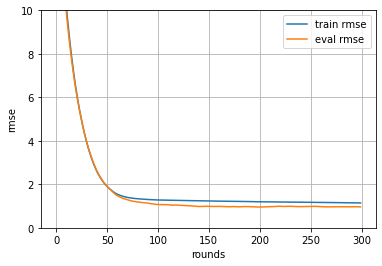

In [38]:
plt.plot(train_metric, label='train rmse')
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.ylim(0, 10)

plt.xlabel('rounds')
plt.ylabel('rmse')
plt.grid(True)
plt.show()

In [39]:
y_total_pred = y_lasso_pred*0.0 + y_ridge_pred*0.0 + y_svc_pred*0.0 + y_lgb_oof_train*1.0

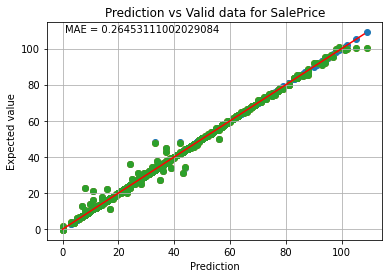

In [40]:
#plt.scatter(y_train, y_lasso_pred)
#plt.scatter(y_train, y_ridge_pred)
plt.scatter(y_train, y_svc_pred)
plt.scatter(y_train, y_lgb_oof_train)
plt.scatter(y_train, y_total_pred)



plt.title("Prediction vs Valid data for SalePrice")
plt.xlabel("Prediction")
plt.ylabel("Expected value")
# Fitting line
x = np.arange(0, max(y_train))
y = x
plt.plot(x,y,color='red')

# MAE
result_mae = mean_absolute_error(y_train, y_total_pred)
#result_mae = mean_absolute_error(y_train, y_lgb_oof_train)
#result_rmsle = rmsle(y_train.values, y_lgb_oof_train)

plt.text(1, max(y_train), 'MAE = {}'.format(result_mae))

# Grid on
plt.grid(True)

In [41]:
# Average of Prediction data (LightGBM)
y_lgb_test_pred = sum(y_lgb_preds)/len(y_lgb_preds)

In [42]:
submit_sample[1] = y_lgb_test_pred
submit_sample.to_csv('submit.csv',index = False,  header=None)

In [43]:
submit_sample.head()

,0,1
0,2016-04-01,61.020092
1,2016-04-02,68.875727
2,2016-04-03,74.557969
3,2016-04-04,57.008723
4,2016-04-05,17.247618
